<a href="https://colab.research.google.com/github/danisJIOGUE/statistics-application/blob/bance_statapp/predict_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default risk rating in non profit microfinance : case of non profit orgnisation KIVA

The main purpose of this study is to predict the defaut risk of the client of the **non profit organisation Kiva**. To archieve this goal we will use some predictions models to find the score of each lender. The following step will be use to build our models :
# I) Explonatory data analysis
### a) Merge the dataset
### b) Univariate analysis
### c) Bivariate analysis
### d) Multivariate analysis
# II) Modelisation
### a) Resampling our dataset
### b) Selection of the variable
### c) Implementation

# Explonatory data analysis
As define previously, we will first start to merging our datasets. Before doing this we will install all the libraries.
### a) Merge the dataset

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from subprocess import check_output
from plotnine import *
from google.colab import drive
from sklearn.impute import KNNImputer
#import pycountry_convert as pc
drive.mount('/content/drive')

Mounted at /content/drive


     |████████████████████████████████| 983kB 15.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=af392e27da885ed214bfce4bce76c61134c656ed52ab3148c06a638e8a86011d
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
from langdetect import detect

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


 Now we have install the librabries, We will upload our datasets. We have two datasets :
> - Loan dataset : contain some basics information in the lender
- Description dataset : contain the informations which are related to the description of each loan.

In [ ]:
#Detection of the dataset'encoding
import chardet

#Loan dataset
with open("/content/drive/My Drive/Stat_App/loans.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.7291077209623456, 'encoding': 'ISO-8859-1', 'language': ''}

In [ ]:
loan = pd.read_csv('/content/drive/My Drive/Stat_App/loans.csv', encoding ='ISO-8859-1',  sep=";")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,4,11,30,32,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Description dataset
with open("/content/drive/My Drive/Stat_App/description.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [ ]:
db_desc = pd.read_csv('/content/drive/My Drive/Stat_App/description.csv', encoding ='utf-8',  sep=";")

In [ ]:
print('The shape (nb obs ; nb var) of the data set : \n\n loan :', loan.shape,'\n description : ', db_desc.shape)

The shape (nb obs ; nb var) of the data set : 

 loan : (42181, 42) 
 description :  (3182, 19)


In [ ]:
db_desc.head(2)

id      loan_name  ... repayment_interval distribution_model
0  156  Marks Antonio  ...            monthly      field_partner
1  173            NaN  ...            monthly      field_partner

[2 rows x 19 columns]

In [ ]:
loan.head(2)

id description.languages status  ... settlement_date        lat        lon
0  156                    en   paid  ...      16/09/2006  12.150833 -86.268333
1  156                    en   paid  ...      16/09/2006  12.150833 -86.268333

[2 rows x 42 columns]

Now have have the quick look of our datasets, we are going to start the pretraitement for the dataset **loans** which contain many duplicates observations.
* Drop dupplicates observations

In [ ]:
## Number of dupplicates values (loan database)
loan.duplicated(subset=['id']).sum()

37177

In [ ]:
#create variable dupplicates which gives the status of each id
loan.id.duplicated().value_counts()

True     37177
False     5004
Name: id, dtype: int64

In [ ]:
#Database without dupplicates values
data = loan.drop_duplicates(subset='id')
data.reset_index(inplace=True)
data = data.drop('index',axis=1)
data.head(2)

id description.languages     status  ... settlement_date        lat        lon
0  156                    en       paid  ...      16/09/2006  12.150833 -86.268333
1  173                    en  defaulted  ...             NaN  31.284167  34.250833

[2 rows x 42 columns]

In [ ]:
print('The shape of our new dataset without duplicates : ', data.shape)

The shape of our new dataset without duplicates :  (5004, 42)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5004 entries, 0 to 5003
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      5004 non-null   object 
 1   description.languages                   3267 non-null   object 
 2   status                                  5004 non-null   object 
 3   funded_amount                           5004 non-null   object 
 4   paid_amount                             4904 non-null   object 
 5   activity                                5004 non-null   object 
 6   sector                                  5004 non-null   object 
 7   location.country_code                   4962 non-null   object 
 8   location.country                        5004 non-null   object 
 9   location.town                           4871 non-null   object 
 10  location.geo.level                      5002 non-null   obje

This caption show that our loan dataset contains many variables which have no observations. These variables will be removed in our dataset, we are going keep only those which have the information.

In [ ]:
#list of unuseful variables
useless = ['description.languages','activity','partner_id','location.geo.level','location.town','location.country_code',"borrowers.first_name",'borrowers.last_name',"video.youtube_id"]

In [ ]:
data = data.drop(useless, axis = 1)
data.shape

(5004, 33)

In [ ]:
data.head(2)

id     status funded_amount  ... settlement_date        lat        lon
0  156       paid           500  ...      16/09/2006  12.150833 -86.268333
1  173  defaulted           600  ...             NaN  31.284167  34.250833

[2 rows x 33 columns]

* Merge dataset laon with description

*These* datasets do not have the same size we are going to merge them.

In [ ]:
resul = pd.merge(data, db_desc, how = 'left', on = ['id','id'])

In [ ]:
resul.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'location.country', 'borrowers.gender', 'borrowers.pictured',
       'terms.disbursal_amount', 'terms.disbursal_currency',
       'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'loan_name', 'description', 'description_translated', 'loan_use',
       'country_code', 'country_name', 'town_name', 'currency_policy',
       'currency_exchange_coverage_rate', 'partner_id', 'lender_term',
       'num_lenders_total', 'tags', 'borrow

After merging our datasets, we are now going to look for the missing values. This analysis will help us to see whether it is good or not to merge the dataset.

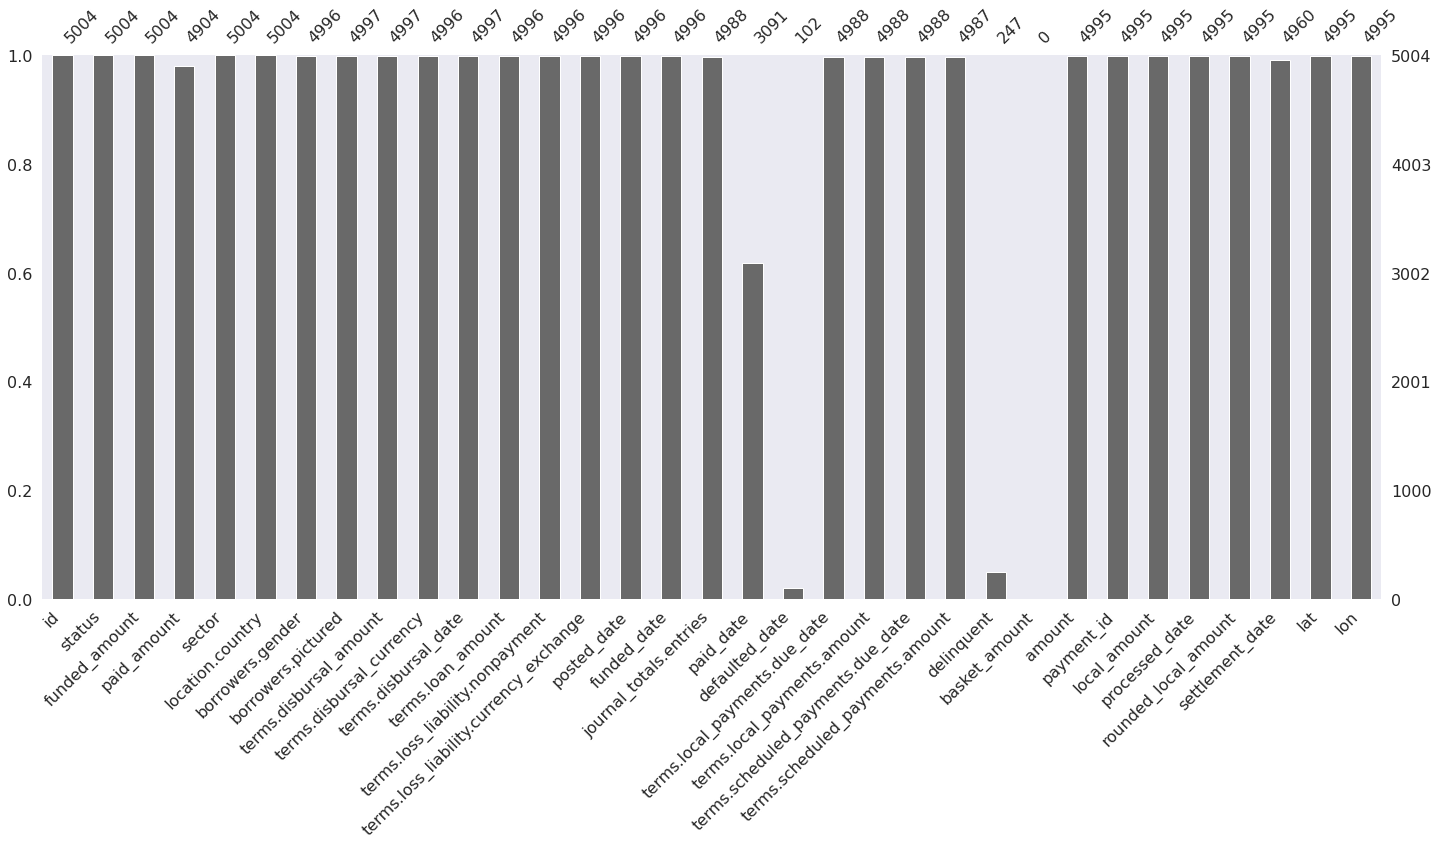

In [ ]:
# Missing value of the loan dataset
msno.bar(data)

With thses above graphics, we see that the merging dataset has many missing values. Indeed, the description dataset contribute to reduce the information which are contained in the loan dataset. So, we will use only the loan dataset.

### b) Univariate analysis
In this part we will find out the information behind the variables.
* **Qualitative variable**
  * Loan Status

In [ ]:
pd.crosstab(data.status,"freq")

col_0         freq
status            
101              1
F                1
defaulted      100
in_repayment  1818
paid          3084

In [ ]:
data.status.unique()

array(['paid', 'defaulted', 'in_repayment', '101', 'F'], dtype=object)

In [ ]:
#Drop modality '101' and 'F'
data = data[data.status != '101']
data = data[data.status != 'F']
data = data[data.status != 'in_repayment']
data.shape
conditions = [
    (data.status == 'defaulted'),
    (data.status == 'paid')
]
values = [1,0]

data['target'] = np.select(conditions, values)
pd.crosstab(data.target,"freq")

col_0   freq
target      
0       3084
1        100

* Sector

In [ ]:
pd.crosstab(data['sector'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0            freq
sector               
Agriculture     17.02
Arts             3.11
Clothing         8.79
Construction     2.42
Education        0.13
Entertainment    0.09
Food            30.50
Health           0.94
Housing          0.82
Manufacturing    1.10
Personal Use     0.19
Retail          22.83
Services         8.76
Transportation   2.95
Wholesale        0.35

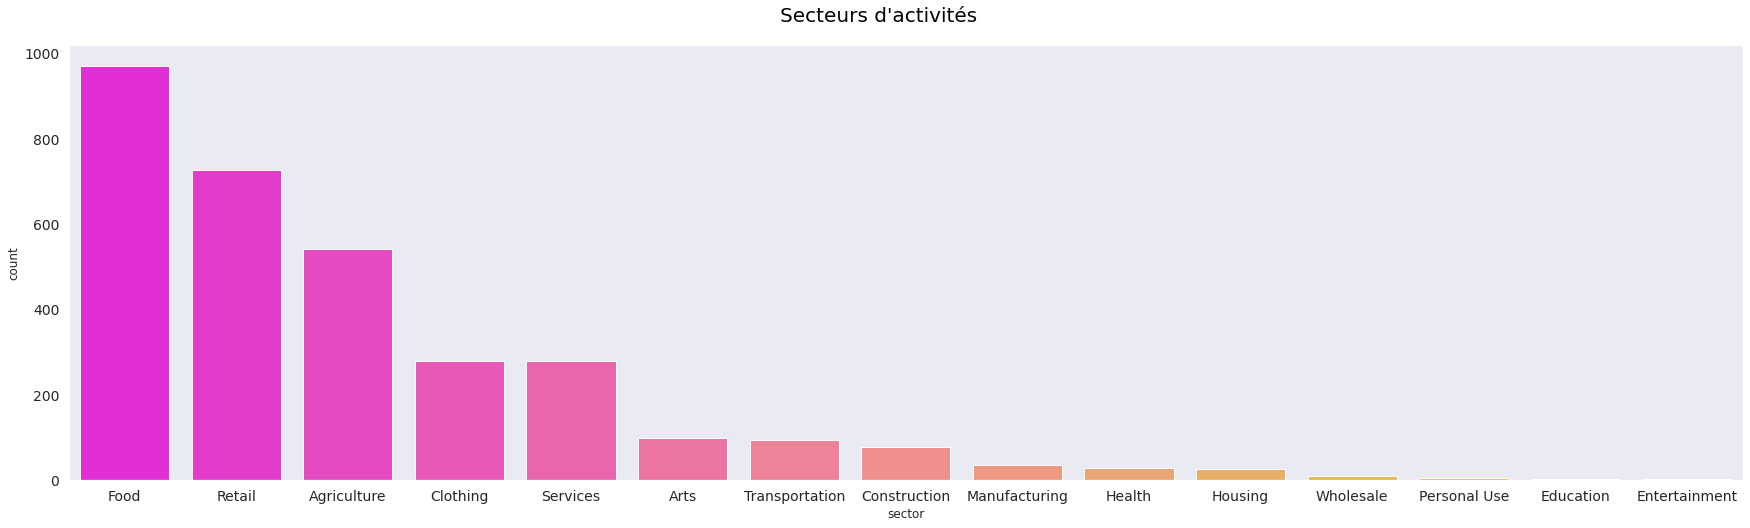

In [ ]:
plt.figure(figsize=(30,8))
sns.set(rc={"axes.grid":False,'xtick.labelsize':14,'ytick.labelsize':14})
plt.gcf().text(.5, .93, "Secteurs d'activités", fontsize = 20, color='black' ,ha='center', va='center')
ax = sns.countplot(x=data['sector'] , order =data['sector'].value_counts().index , palette="spring")

plt.show()

In [ ]:
Bien_Menage = ['Clothing','Housing','Personnal Use']
autre_secteur = ['Services','Education','Transportation','Arts','Health','Construction','Manufacturing','Entertainment','Wholesale']
conditions = [
    (data.sector == 'Agriculture'),
    (data.sector == 'Food'),
    (data.sector == 'Retail'),
    (data.sector == 'Clothing') | (data.sector == 'Housing') | (data.sector == 'Personal Use'),
    (data.sector == 'Services') | (data.sector == 'Education') | (data.sector == 'Transportation') | (data.sector == 'Arts') | (data.sector == 'Health') | (data.sector == 'Services') | (data.sector == 'Construction') |  (data.sector == 'Manufacturing') | (data.sector == 'Entertainment') | (data.sector == 'Wholesale')
]
values = ['Agriculture','Food','Retail','Bien_Menage','autre_secteur']
data.sector = np.select(conditions, values)

pd.crosstab(data['sector'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0           freq
sector              
Agriculture    17.02
Bien_Menage     9.80
Food           30.50
Retail         22.83
autre_secteur  19.85

* Borrower gender

In [ ]:
# Unique modalité of this variable
data.rename(columns={'borrowers.gender':'gender'}, inplace = True)
len(pd.unique(data['gender']))

pd.crosstab(data['gender'].isna(),'freq')

col_0   freq
gender      
False   3181
True       3

We have 3 borrowers who do not give the gender.

In [ ]:
# Suppression des missings values
data = data.dropna(how='all', subset=['gender'])

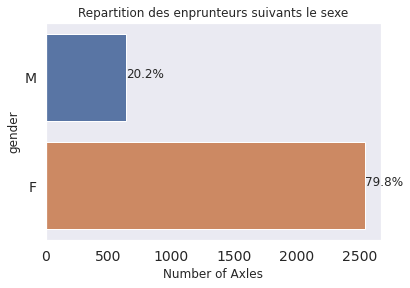

In [ ]:
ax = sns.countplot(y="gender", data=data)
plt.title('Repartition des enprunteurs suivants le sexe')
plt.xlabel('Number of Axles')

total = len(data['gender'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Countries repartition

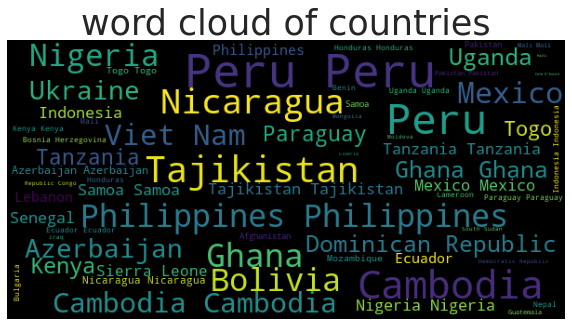

In [ ]:
# Wordcloud of the country
data.rename(columns={'location.country':'country_name'}, inplace = True)

names = data["country_name"][~pd.isnull(data["country_name"])]
#print(names)
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(names))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.title("word cloud of countries", fontsize=35)
plt.axis("off")
plt.show() 

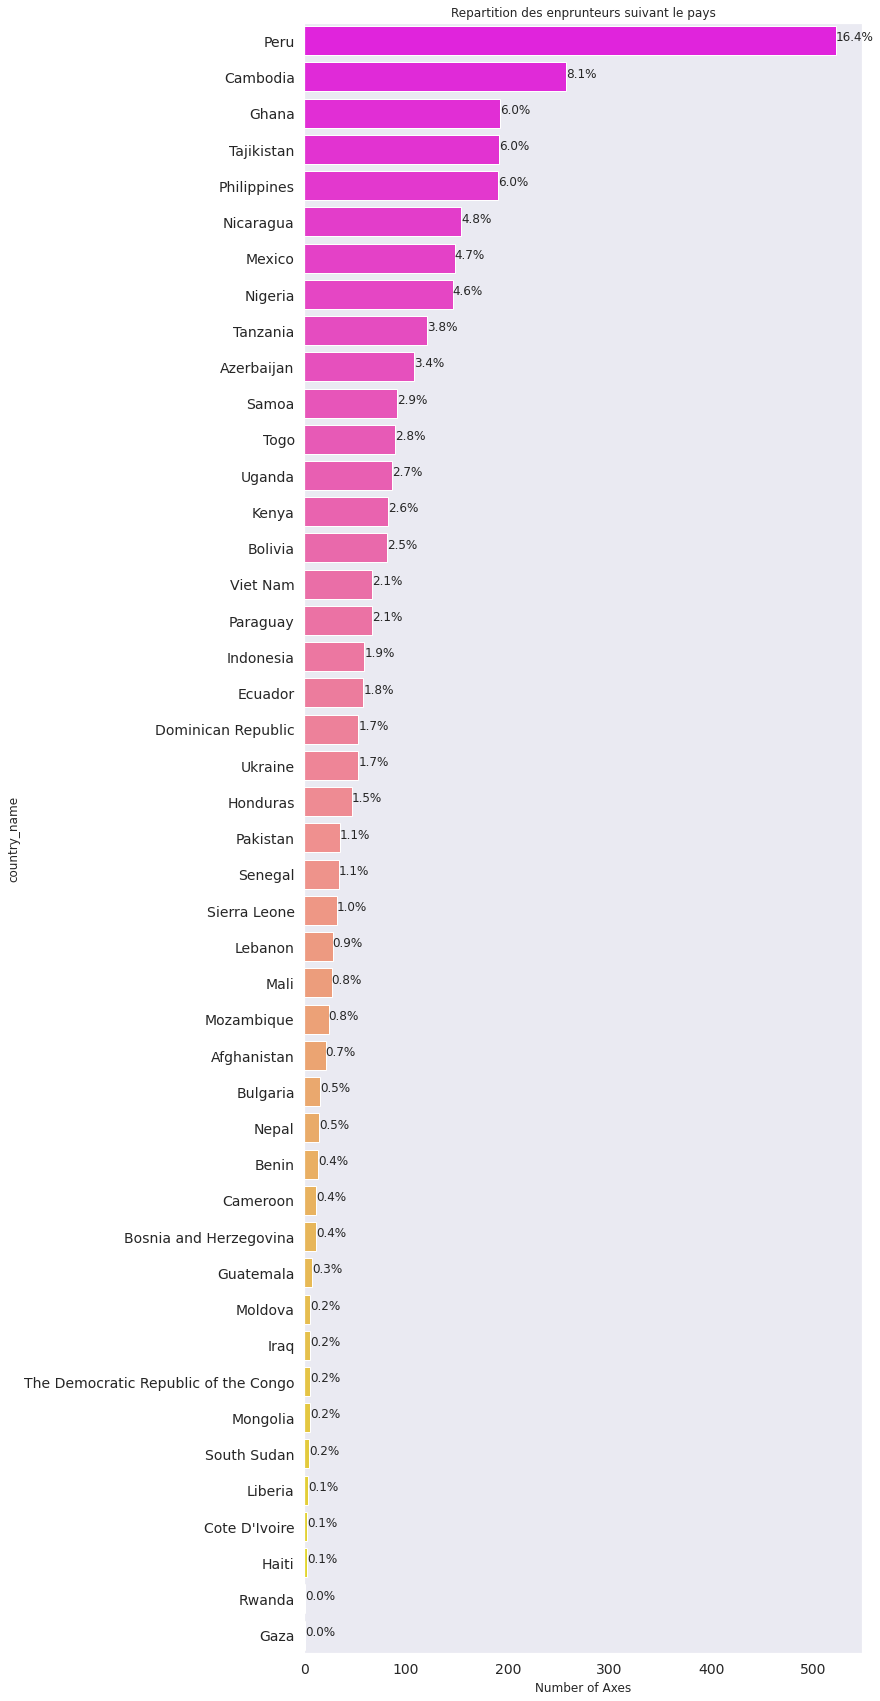

In [ ]:
plt.figure(figsize=(10,30))
ax = sns.countplot(y="country_name", data=data, order =data['country_name'].value_counts().index , palette="spring")
#ax = sns.countplot(x=data['SECTOR_NAME'] )

plt.title('Repartition des enprunteurs suivant le pays')
plt.xlabel('Number of Axes')

total = len(data['country_name'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [ ]:
# grouping the country due to their continent
def pays_par_continent(country_name):
    while True:
      try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
        break
      except KeyError:
        return 'Unknown'

data['CONTINENT'] = data['country_name'].apply(pays_par_continent)

#vérification du rendu :
data['CONTINENT'].unique()

array(['North America', 'Unknown', 'Africa', 'Europe', 'Asia', 'Oceania',
       'South America'], dtype=object)

In [ ]:
# We have the modality Unknown which we are going to give the real value
# looking for the country correspond to unknow
data[data['CONTINENT']=='Unknown']['country_name'].unique()

array(['Gaza', 'The Democratic Republic of the Congo', "Cote D'Ivoire"],
      dtype=object)

In [ ]:
data.CONTINENT = np.where((data.country_name == 'The Democratic Republic of the Congo') | (data.country_name == "Cote D'Ivoire"),'Africa',data.CONTINENT)
data.CONTINENT = np.where((data.country_name == 'Gaza'),'Asia',data.CONTINENT)

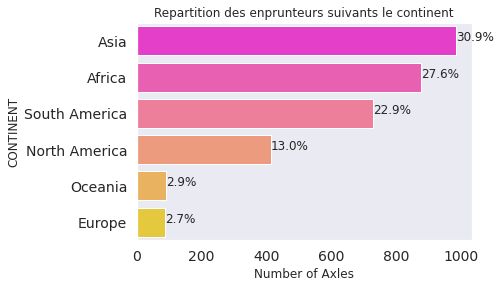

In [ ]:
#plt.figure(figsize=(10,30))
ax = sns.countplot(y="CONTINENT", data=data, order =data['CONTINENT'].value_counts().index , palette="spring")
#ax = sns.countplot(x=data['SECTOR_NAME'] )

plt.title('Repartition des enprunteurs suivants le continent')
plt.xlabel('Number of Axles')

total = len(data['CONTINENT'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Borrower pictured

In [ ]:
data.rename(columns={'borrowers.pictured':'borrower_pictured'}, inplace = True)

pd.crosstab(data['borrower_pictured'],'freq').apply(lambda r: 100 * r/len(data), axis=1)

col_0                   freq
borrower_pictured           
True               49.984282
FALSE               0.094310
TRUE               49.921408

In [ ]:
conditions = [
    (data.borrower_pictured == 'TRUE') | (data.borrower_pictured == 'True'),
    (data.borrower_pictured == 'FALSE')
]
values = ['TRUE','FALSE']

data['borrower_pictured'] = np.select(conditions, values)
pd.crosstab(data['borrower_pictured'],'freq')

col_0              freq
borrower_pictured      
0                  1590
FALSE                 3
TRUE               1588

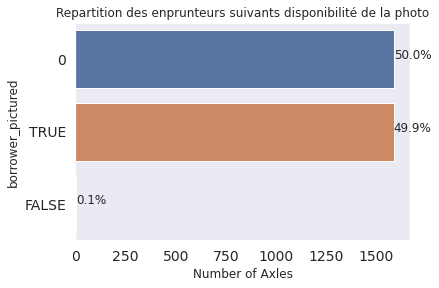

In [ ]:
ax = sns.countplot(y="borrower_pictured", data=data)
plt.title('Repartition des enprunteurs suivants disponibilité de la photo')
plt.xlabel('Number of Axles')

total = len(data['borrower_pictured'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Date of payment (funded date, posted date)

In [ ]:
data.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'country_name', 'gender', 'borrower_pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'target', 'CONTINENT'],
      dtype='object')

In [ ]:
# Conversion des variables en datetime

data["posted_date"] = pd.to_datetime(data["posted_date"])
data["funded_date"] = pd.to_datetime(data["funded_date"])
data["terms.disbursal_date"] = pd.to_datetime(data["terms.disbursal_date"])
data["settlement_date"] = pd.to_datetime(data["settlement_date"])

data["posted_date"].dt
data["funded_date"].dt
data["terms.disbursal_date"].dt
data["settlement_date"].dt

# Ajout des variables années à notre dataset
data["posted_date"] = data["posted_date"].dt.year
data["funded_date"] = data["funded_date"].dt.year
data["terms.disbursal_date"] = data["terms.disbursal_date"].dt.year
data["settlement_date"] = data["settlement_date"].dt.year

# Définition des variables pour la représentation graphique
df1 = pd.crosstab(data["posted_date"],"freq")
df2 = pd.crosstab(data["funded_date"],"freq")
df3 = pd.crosstab(data["terms.disbursal_date"],"freq")
df4 = pd.crosstab(data["settlement_date"],"freq")

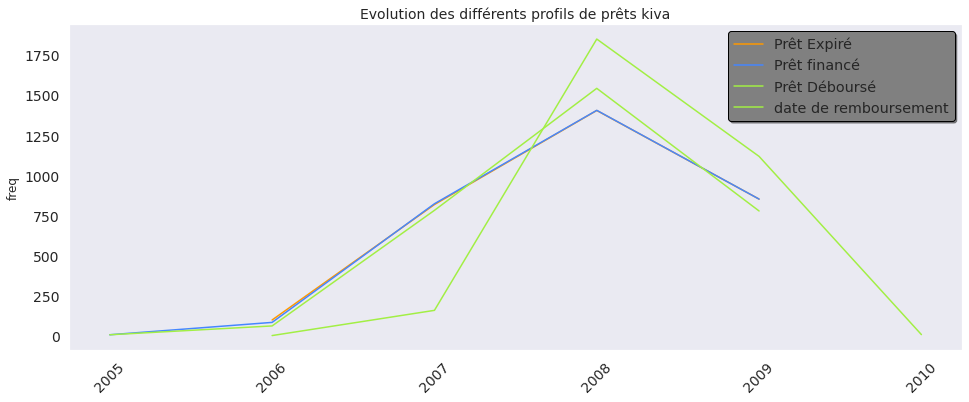

In [ ]:
plt.figure(figsize=(16,6))
sns.set_style("dark")
##sns.set(rc={"axes.facecolor":"#283747", "axes.grid":False,'xtick.labelsize':10,'ytick.labelsize':10})
plt.title("Evolution des différents profils de prêts kiva",fontsize = 14)
plt.xticks(rotation=45) # Rotating X tickts by 45 degrees
sns.lineplot(x = df1.index.values, y = df1['freq'] , color = '#ff9900' , label= 'Prêt Expiré')
sns.lineplot(x = df2.index.values, y = df2['freq'] , color = '#4586ff' , label = 'Prêt financé')
sns.lineplot(x = df3.index.values, y = df3['freq'] , color = '#a2ef44' , label = 'Prêt Déboursé')
sns.lineplot(x = df4.index.values, y = df4['freq'] , color = '#a2ef44' , label = 'date de remboursement')
plt.legend(facecolor= 'grey' , fontsize='large' , edgecolor = 'black' ,shadow=True) # Legend formatting
plt.legend(facecolor= 'grey' , fontsize='large' , edgecolor = 'black' ,shadow=True) # Legend formatting
plt.show()

* **Quantitative variable**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 0 to 5002
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3181 non-null   object 
 1   status                                  3181 non-null   object 
 2   funded_amount                           3181 non-null   object 
 3   paid_amount                             3081 non-null   object 
 4   sector                                  3181 non-null   object 
 5   country_name                            3181 non-null   object 
 6   gender                                  3181 non-null   object 
 7   borrower_pictured                       3181 non-null   object 
 8   terms.disbursal_amount                  3181 non-null   object 
 9   terms.disbursal_currency                3181 non-null   object 
 10  terms.disbursal_date                    3181 non-null   int6

In [ ]:
data['funded_amount'] = pd.to_numeric(data['funded_amount'], downcast='float')
data['paid_amount'] = pd.to_numeric(data['paid_amount'], downcast='float')

In [ ]:
numerical_col = data.select_dtypes(include =["number"]).columns.values
numerical_col

array(['funded_amount', 'paid_amount', 'terms.disbursal_date',
       'terms.loan_amount', 'posted_date', 'funded_date',
       'journal_totals.entries', 'basket_amount', 'amount', 'payment_id',
       'settlement_date', 'lat', 'lon', 'target'], dtype=object)

In [ ]:
def Num_info(df, numeric_column):
  """ Fonction qui affiche les infos sur les variables quantitatives
    le nombre de missings et leur pourcentage """
  df_result = pd.DataFrame(columns=["columns","null_values","null_percent"])
    
  df_temp=pd.DataFrame()
  for value in numeric_column:

    df_temp["columns"] = [value]
    df_temp["null_values"] = df[value].isna().sum()
    df_temp["null_percent"] = (df[value].isna().sum()/len(df)*100).round(1)
    df_result = df_result.append(df_temp)
    
  df_result.sort_values("null_values", ascending =False, inplace=True)
  df_result.set_index("columns", inplace=True)
  return df_result

In [ ]:
df_num = Num_info(data,numerical_col)
df_num

null_values  null_percent
columns                                         
basket_amount                 3181         100.0
paid_amount                    100           3.1
settlement_date                 35           1.1
funded_amount                    0           0.0
terms.disbursal_date             0           0.0
terms.loan_amount                0           0.0
posted_date                      0           0.0
funded_date                      0           0.0
journal_totals.entries           0           0.0
amount                           0           0.0
payment_id                       0           0.0
lat                              0           0.0
lon                              0           0.0
target                           0           0.0

In [ ]:
var_quanti = ['amount','paid_amount','funded_amount','journal_totals.entries']
data[var_quanti].describe()

amount  paid_amount  funded_amount  journal_totals.entries
count  3181.000000  3081.000000    3181.000000             3181.000000
mean    107.415929   681.986389     680.084900                1.454574
std     142.532848   600.016907     593.962952                0.672619
min       0.080000    25.000000      25.000000                1.000000
25%      42.000000   325.000000     325.000000                1.000000
50%      69.000000   525.000000     525.000000                1.000000
75%     110.000000   900.000000     900.000000                2.000000
max    1818.100000  5000.000000    5000.000000                7.000000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

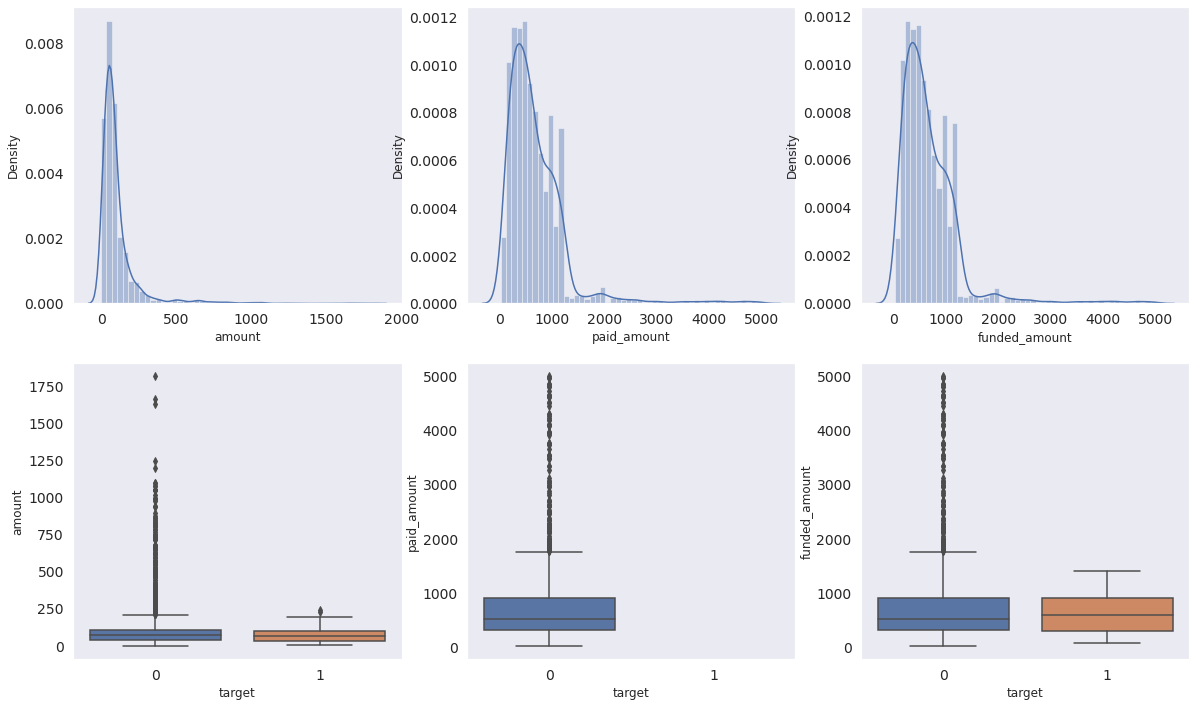

In [ ]:
numerical_cols1 = ['amount','paid_amount','funded_amount']
plt.figure(figsize=(20,12))

i=1
for col in numerical_cols1:
    plt.subplot(2,3,i)
    sns.distplot(data[col])
    plt.subplot(2,3,3+i)
    sns.boxplot(y=data[col], x = data['target'])
    i+=1

In [ ]:
# Remplacement des données 95% percetile value
Q4 = data['paid_amount'].quantile(0.90) # Get 95th quantile
print("Le nombre total de paid_amount est de : ",len(data[data['paid_amount'] >= Q4]))
data.loc[data['paid_amount'] >= Q4, 'paid_amount'] = Q4 # outlier capping

Q4 = data['funded_amount'].quantile(0.90) # Get 95th quantile
print("Le nombre total de funded_amount est de :",len(data[data['funded_amount'] >= Q4]))
data.loc[data['funded_amount'] >= Q4, 'funded_amount'] = Q4 # outlier capping

Le nombre total de paid_amount est de :  357
Le nombre total de funded_amount est de : 370


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


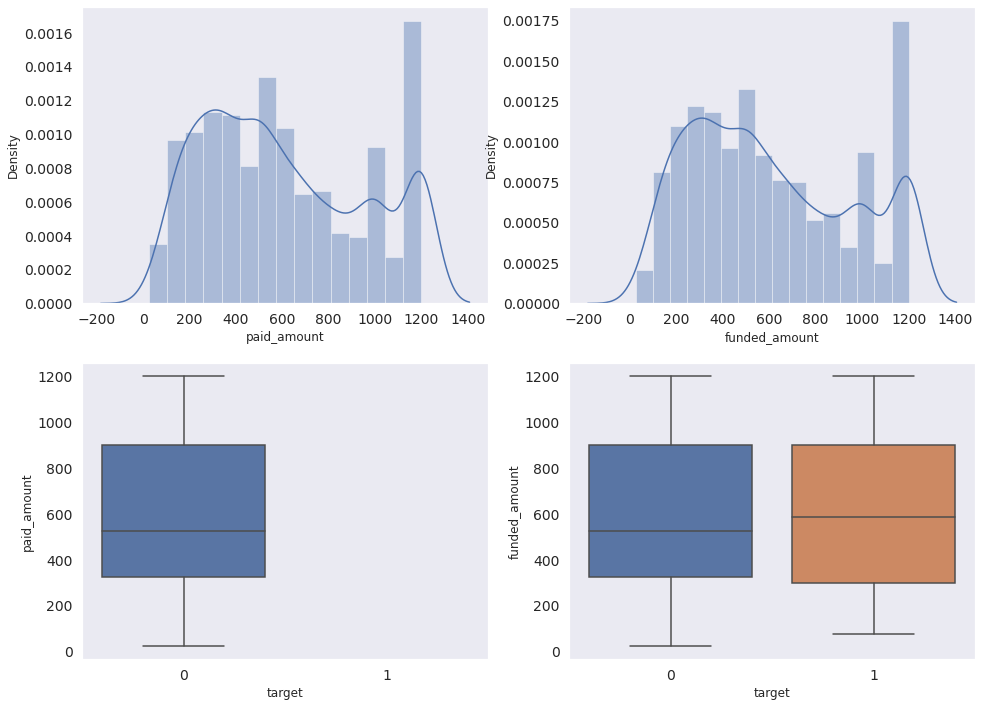

In [ ]:
numerical_cols1 = ['paid_amount', 'funded_amount']
plt.figure(figsize=(16,12))

i=1
for col in numerical_cols1:
    plt.subplot(2,2,i)
    sns.distplot(data[col])
    plt.subplot(2,2,2+i)
    sns.boxplot(y=data[col], x = data['target'])
    i+=1

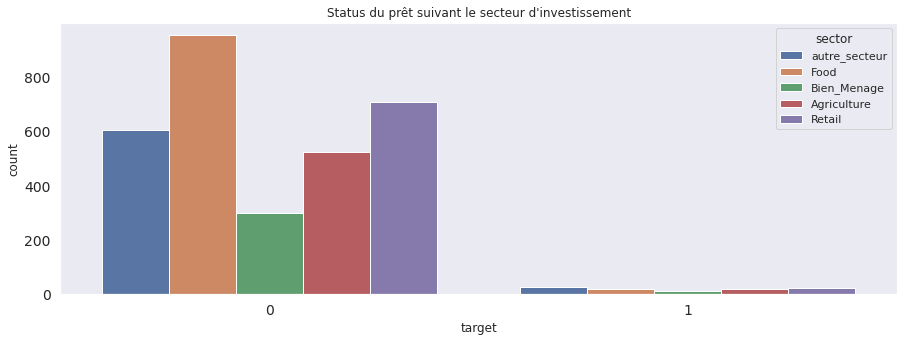

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="target", hue='sector', data=data).set_title("Status du prêt suivant le secteur d'investissement");

#### - Categorials variables
The aim of this session is to sump up the univariate analysis in term of doing some basics modifications in our previous variables like recode, define a label and so one.

In [ ]:
data.sector.value_counts()

Food             970
Retail           727
autre_secteur    632
Agriculture      540
Bien_Menage      312
Name: sector, dtype: int64

In [ ]:
data.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'country_name', 'gender', 'borrower_pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'target', 'CONTINENT', 'sector_cat'],
      dtype='object')

In [ ]:
categorical_var = ['gender','borrower_pictured','terms.loss_liability.nonpayment']
data[categorical_var] = data[categorical_var].astype('category')
data['gender'] = data['gender'].cat.codes
data['borrower_pictured'] = data['borrower_pictured'].cat.codes
data['terms.loss_liability.nonpayment'] = data['terms.loss_liability.nonpayment'].cat.codes

In [ ]:
# We can group the sector variable
others = ['Manufecturing', 'Health', 'Housing', 'Wholesale', 'Personal Use', 'Education', 'Entertainment']
data['sector_cat'] = np.where(data['sector'].isin(others), "Other", data['sector'])

In [ ]:
# Save the data without dummy
data.to_csv('/content/drive/My Drive/Stat_App/data_without_dummy.csv',index = False)

In [ ]:
# We can create dummy variables
data = pd.get_dummies(data, columns=['sector_cat','CONTINENT','terms.loss_liability.currency_exchange'], prefix = ['sector','continent','currency_exchange'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 0 to 5002
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3181 non-null   object 
 1   status                             3181 non-null   object 
 2   funded_amount                      3181 non-null   float32
 3   paid_amount                        3081 non-null   float32
 4   sector                             3181 non-null   object 
 5   country_name                       3181 non-null   object 
 6   gender                             3181 non-null   int8   
 7   borrower_pictured                  3181 non-null   int8   
 8   terms.disbursal_amount             3181 non-null   object 
 9   terms.disbursal_currency           3181 non-null   object 
 10  terms.disbursal_date               3181 non-null   int64  
 11  terms.loan_amount                  3181 non-null   float

In [ ]:
# Converting amount data
amount_var = ['terms.disbursal_amount','terms.local_payments.amount','terms.scheduled_payments.amount','local_amount','rounded_local_amount']
for var in amount_var :
  data[var] = np.where(data[var].isna(),0.0,data[var])
  data[var]=data[var].str.replace(',', '.')
data[amount_var] = data[amount_var].astype('float')

In [ ]:
date_var = ['terms.disbursal_date','paid_date','defaulted_date','terms.local_payments.due_date','terms.scheduled_payments.due_date','processed_date']
data = data.drop(['id','status','terms.disbursal_currency','country_name','sector','delinquent', 'terms.scheduled_payments.amount','rounded_local_amount', 'basket_amount', 'sector_Agriculture', 'continent_Africa','currency_exchange_none'], axis=1)
data = data.drop(date_var, axis=1)
data

funded_amount  ...  currency_exchange_shared
0             500.0  ...                         0
1             600.0  ...                         0
2             500.0  ...                         0
3             500.0  ...                         0
4             575.0  ...                         0
...             ...  ...                       ...
4996          150.0  ...                         0
4997          350.0  ...                         0
5000          225.0  ...                         0
5001           75.0  ...                         0
5002          475.0  ...                         0

[3181 rows x 29 columns]

> Missing value treatment : with this caption, we have the quick look in the distribution of the missing values in our final dataset.

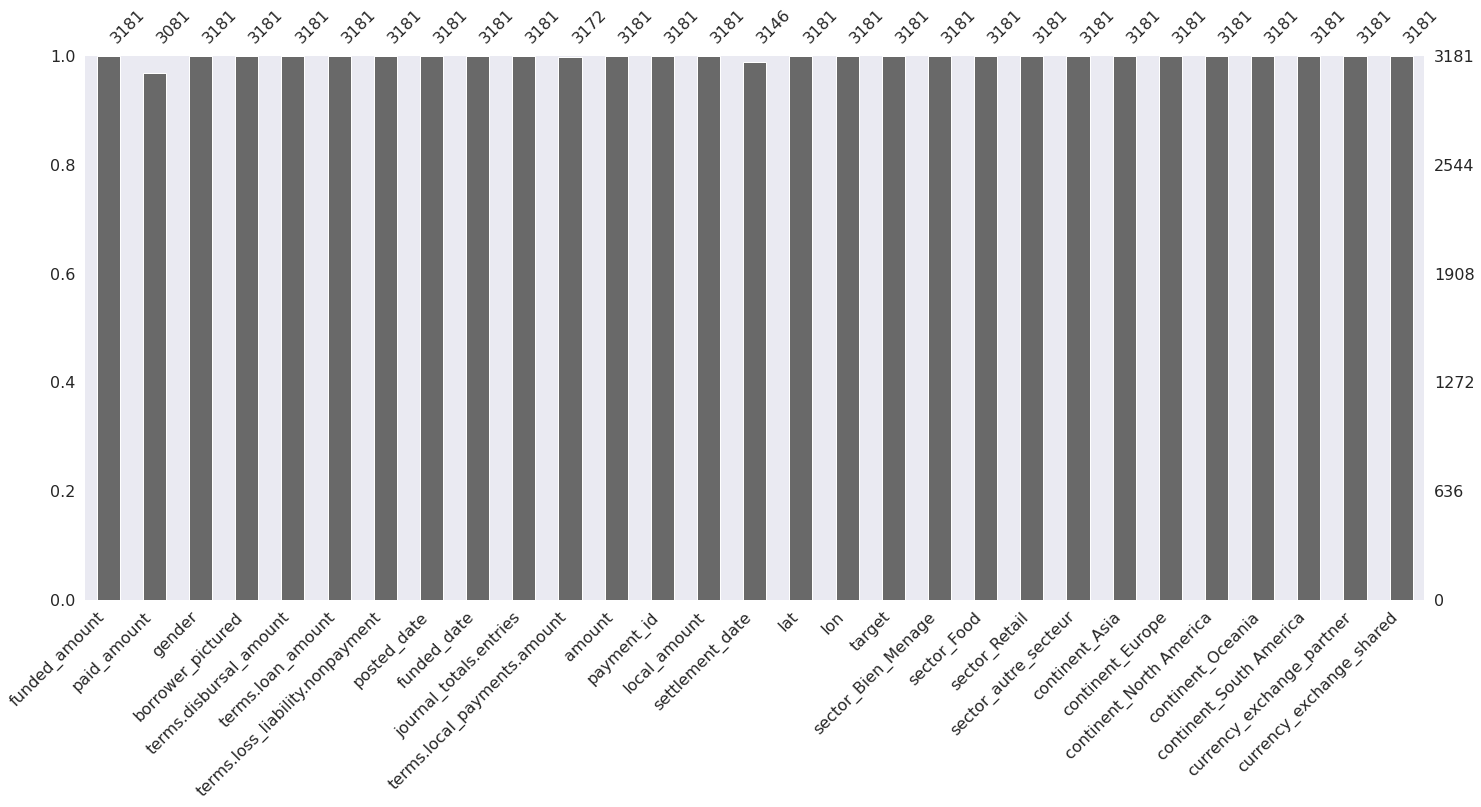

In [ ]:
msno.bar(data)

In [ ]:
# Save of data with dummies
data.to_csv('/content/drive/My Drive/Stat_App/data_dummy.csv',index = False)

In [ ]:
# Imputation of the variable which already contain missing values.
imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(data)
imputed = pd.DataFrame(imputed)
imputed.columns = data.columns
data = imputed

In [ ]:
# Save of data with dummies and imput by knn
data.to_csv('/content/drive/My Drive/Stat_App/data_dummy_imput.csv',index = False)

### c) Bivariate analysis

We will do a cross-analysis of the explanatory variables on the target variable. This gives an idea of the effect of borrower characteristics on the default probability.

In [ ]:
pd.crosstab(data.target,data['CONTINENT'],margins=True)

KeyError: ignored

In [ ]:
pd.crosstab(data.target,data['gender'],margins=True)

gender   0.0  1.0   All
target                 
0.0     2466  615  3081
1.0       74   26   100
All     2540  641  3181

In [ ]:
pd.crosstab(data.target,data['sector'],margins=True)

KeyError: ignored

In [ ]:
pd.crosstab(data.target,data['borrower_pictured'],margins=True)

borrower_pictured   0.0  1.0   2.0   All
target                                  
0.0                1540    3  1538  3081
1.0                  50    0    50   100
All                1590    3  1588  3181

In [ ]:
data.groupby(['target']).mean()

funded_amount  ...  currency_exchange_shared
target                 ...                          
0.0        608.089906  ...                  0.033431
1.0        618.000000  ...                  0.000000

[2 rows x 28 columns]

### d) Multivariate analysis : Description of the defaulted loan

The goal of this part is to do a multivariate analysis of the features with the intention of highlighting the features that are more likely to predict our target variable. To do this we will use the principal component analysis (PCA). 

In [ ]:
!pip install prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import prince
import math as mt
from scipy.stats import chi2
from sklearn.neighbors import KNeighborsClassifier


#### ***Implementation and choice of axis***

In [ ]:
data.head()

funded_amount  ...  currency_exchange_shared
0          500.0  ...                       0.0
1          600.0  ...                       0.0
2          500.0  ...                       0.0
3          500.0  ...                       0.0
4          575.0  ...                       0.0

[5 rows x 29 columns]

In [ ]:
# Data for PCA
y = data.target
dataPCA = data.drop('target',axis = 1)

# Implementation of PCA
pca = prince.PCA(n_components=10, n_iter=3, rescale_with_mean=True,
   rescale_with_std=True,copy=True,check_input=True,engine='auto', random_state=42)
pca = pca.fit(dataPCA)

# Choice of the axis
pca.explained_inertia_

array([0.1489655 , 0.12662061, 0.10182566, 0.07955601, 0.05672436,
       0.05336063, 0.0502158 , 0.04604947, 0.04099315, 0.04013183])

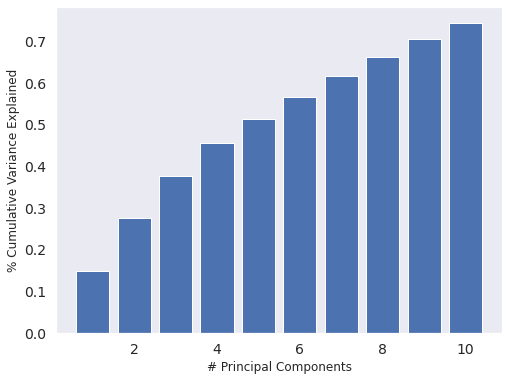

In [ ]:
# Calculate cumulative explained variance across all PCs
cum_exp_var = []
var_exp = 0

for i in pca.explained_inertia_:
    var_exp += i
    cum_exp_var.append(var_exp)



# Plot cumulative explained variance for all PCs

fig,ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,11), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

In [ ]:
pca.eigenvalues_

array([4.17103388, 3.54537704, 2.85111855, 2.22756825, 1.58828206,
       1.49409777, 1.40604239, 1.28938513, 1.14780826, 1.12369137])

In [ ]:
## KMO index
R= dataPCA.corr()

inv_R=np.linalg.inv(R)
A=np.zeros(shape=(inv_R.shape[0],inv_R.shape[1]))
for i in range(inv_R.shape[0]):
  for j in range(i+1,inv_R.shape[1]):
    A[i,j]= -inv_R[i,j]/np.sqrt(inv_R[i,i]*inv_R[j,j])
    A[j,i]=A[i,j]
R=R.values

kmo_numerateur= np.sum(R**2)-np.sum(np.diag(R**2))
kmo_denominateur=kmo_numerateur + (np.sum(A**2)-np.sum(np.diag(A**2)))
kmo=kmo_numerateur/kmo_denominateur
print("kmo :",round(kmo,ndigits=2))

kmo : 0.42


In [ ]:
#  Bartlett test
n=dataPCA.shape[0]
p=dataPCA.shape[1]
khi2=-(n-1-(2*p+5)/6)*mt.log(np.linalg.det(R))
ddl=p*(p-1)/2
p_valeur=chi2.pdf(khi2,ddl)

print(p_valeur < 0.01)

True


***Interpretation of the results***

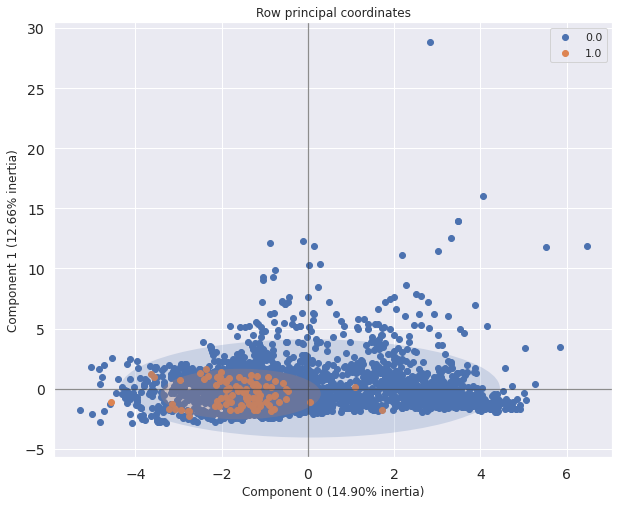

In [ ]:
# Correlation
ax = pca.plot_row_coordinates(dataPCA,  ax=None,    figsize=(10, 8),
    x_component=0, y_component=1,labels=None, color_labels=y,ellipse_outline=False,ellipse_fill=True,show_points=True)

In [ ]:
pca.column_correlations(dataPCA)

0         1  ...         8         9
amount                           0.102250  0.642065  ...  0.041314 -0.102522
borrower_pictured               -0.450688  0.084029  ... -0.036074 -0.131680
continent_Asia                   0.107329  0.072404  ... -0.079435  0.058686
continent_Europe                -0.152966  0.074171  ...  0.469874 -0.105012
continent_North America         -0.220182 -0.125427  ... -0.392576 -0.028310
continent_Oceania               -0.107363 -0.065393  ...  0.108078  0.726684
continent_South America          0.204716 -0.043826  ...  0.162929 -0.368921
currency_exchange_partner        0.408475  0.158516  ... -0.064474  0.053263
currency_exchange_shared         0.369445 -0.034291  ...  0.101960 -0.224304
funded_amount                   -0.365662  0.733542  ... -0.055201  0.023694
funded_date                      0.896963  0.144724  ... -0.045883  0.016411
gender                          -0.157677  0.068860  ... -0.211379 -0.124087
journal_totals.entries          -0.049873 -0.059304  ...  0.189882  0.277163
lat                             -0.219205  0.072349  ... -0.093841 -0.008608
local_amount                     0.108251  0.676022  ...  0.029408 -0.001444
lon                              0.144746  0.133711  ...  0.064523 -0.066326
paid_amount                     -0.366918  0.733409  ... -0.057008  0.025499
payment_id                       0.832139  0.050892  ...  0.021766 -0.048270
posted_date                      0.899370  0.141635  ... -0.048768  0.018220
sector_Bien_Menage              -0.092756  0.022964  ...  0.656015 -0.054461
sector_Food                      0.012465 -0.121947  ... -0.198349 -0.221079
sector_Retail                    0.080958  0.054182  ... -0.352433  0.169710
sector_autre_secteur            -0.106468 -0.003362  ...  0.056319  0.002362
settlement_date                  0.864567  0.132776  ... -0.010603  0.118753
terms.disbursal_amount           0.042258  0.596871  ... -0.004209 -0.013411
terms.loan_amount               -0.193623  0.781469  ... -0.025041 -0.011211
terms.local_payments.amount      0.092297  0.660208  ...  0.025681 -0.004979
terms.loss_liability.nonpayment -0.114420 -0.142651  ... -0.080586 -0.409065

[28 rows x 10 columns]

Text(0.5, 1.0, 'Circle of Correlations')

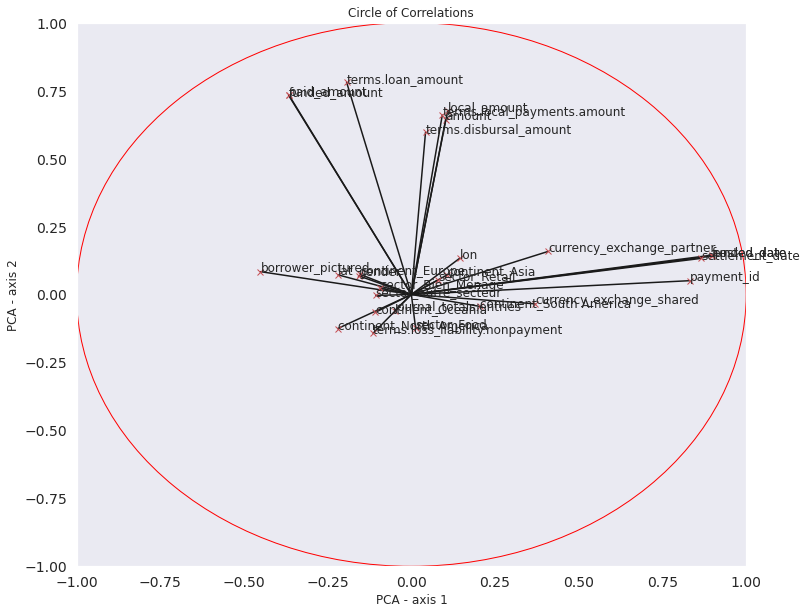

In [ ]:
X = pca.column_correlations(dataPCA).loc[:,:2]
plt.Circle((0,0),radius=20, color='red', fill=False)
circle1=plt.Circle((0,0),radius=1, color='red', fill=False)
plt.figure(figsize=(12,10))
fig = plt.gcf()
fig.gca().add_artist(circle1)
for idx in range(len(X)):
		x = X[0].values[idx]
		y = X[1].values[idx]
		plt.plot([0.0,x],[0.0,y],'k-')
		plt.plot(x, y, 'rx')
		plt.annotate(X.index[idx], xy=(x,y))
  
plt.xlabel('PCA - axis 1')
plt.ylabel("PCA - axis 2")
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title("Circle of Correlations")

# Modelisation
The main target of this session is to use the previous result to build our prediction model. Due to the imbalance of our dataset, we will use some specifics algorithms like **SMOTE** and **Near Miss Algorithm**. We will compare the perfomance both of them to have the best imbalance algorithm for our models. So, we will start for building our imbalance algorithms, and then build our selection model for having the perfomance of our predictions models.
Before starting, we have to sleep our data set into train and test set. The test set, will be use after building the predictions models to evaluate their performance. 


In [4]:
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Probit
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

logit = LogisticRegression()

In [5]:
data = pd.read_csv('/content/drive/My Drive/Stat_App/data_dummy_imput.csv')

In [6]:
# split into 70:30 ratio
Y = data['target']
X = data.drop(['target'], axis=1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=33,stratify = Y)
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(Y_train == 0))) 
print("test set counts of label '1': {}".format(sum(Y_test == 1))) 
print("test set counts of label '0': {}".format(sum(Y_test == 0)))

Before OverSampling, counts of label '1': 70
Before OverSampling, counts of label '0': 2156
test set counts of label '1': 30
test set counts of label '0': 925


## **No resampling : visualization of data**

In [7]:
!pip install prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import prince

In [8]:
print(Y_train.value_counts())
l1,l2=Y_train.value_counts()
print("Label 0 percentage: "+str((l1*100)/Y_train.count()))
print("Label 1 percentage: "+str((l2*100)/Y_train.count()))

0.0    2156
1.0      70
Name: target, dtype: int64
Label 0 percentage: 96.85534591194968
Label 1 percentage: 3.1446540880503147


In [9]:
# Implementation of PCA
pca = prince.PCA(n_components=2, n_iter=3, rescale_with_mean=True,
   rescale_with_std=True,copy=True,check_input=True,engine='auto', random_state=42)
pca = pca.fit(X_train)

X_pic = pca.transform(X_train)
X1 = X_pic.iloc[:, 0]
X2 = X_pic.iloc[:, 1]

In [10]:
df = pd.DataFrame({'X1':X1, 'X2':X2, 'Y':Y_train})

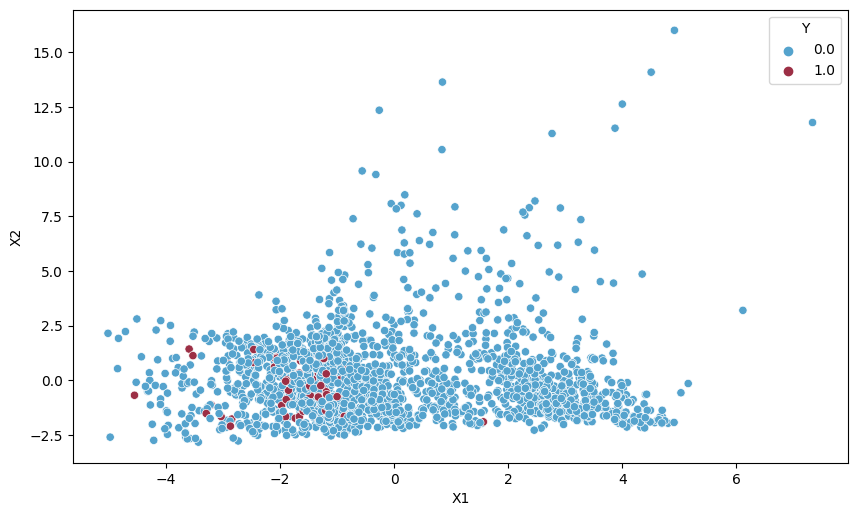

In [11]:
pal = sns.color_palette('tab10')
#sns.set_palette('icefire')
sns.set_palette(['#55a3cd', '#9c2f45'])

# Imblanced Data
plt.figure(figsize=(10,6),dpi=100)

sns.despine(left=True)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df)
plt.show()

## **Imbalance algorithms**



#### 1) ROS (Random Over Sampling)

Random oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset. This may increase the likelihood of overfitting, specially for higher over-sampling rates. Moreover, it may decrease the classifier performance and increase the computational effort.

In [12]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss
from collections import Counter

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
ros = RandomOverSampler(random_state=42)
X_train_ros, Y_train_ros = ros.fit_sample(X_train, Y_train)

print('Resampled dataset shape %s' % Counter(Y_train_ros))
print('x %s', X_train_ros.shape)

Resampled dataset shape Counter({0.0: 2156, 1.0: 2156})
x %s (4312, 28)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [14]:
def cor_principale(dataX,Y_var) :
      pca = prince.PCA(n_components=2, n_iter=3, rescale_with_mean=True,
        rescale_with_std=True,copy=True,check_input=True,engine='auto', random_state=42)
      pca = pca.fit(dataX)
      X_pic = pca.transform(dataX)
      X1 = X_pic.iloc[:, 0]
      X2 = X_pic.iloc[:, 1]
      df_return = pd.DataFrame({'X1':X1, 'X2':X2, 'Y':Y_var})
      return df_return

In [15]:
df_ros = cor_principale(X_train_ros, Y_train_ros)

In [16]:
X_train_ros = pd.DataFrame(X_train_ros,columns=X_train.columns.to_list())
Y_train_ros = pd.DataFrame(Y_train_ros)

#### 2) RUS (random Under Sampling)

In [17]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, Y_train_rus = rus.fit_sample(X_train, Y_train)

print('Resampled dataset shape %s' % Counter(Y_train_rus))
print('x %s', X_train_rus.shape)

Resampled dataset shape Counter({0.0: 70, 1.0: 70})
x %s (140, 28)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [18]:
df_rus = cor_principale(X_train_rus, Y_train_rus)

In [19]:
X_train_rus = pd.DataFrame(X_train_rus,columns=X_train.columns.to_list())
Y_train_rus = pd.DataFrame(Y_train_rus)

##### 3) SMOTE (Synthetic Minority Oversampling Technique)

This algorithm aims to balance class distribution by randomly increasing minority class examples by replicating them. *SMOTE* generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [20]:
sm = SMOTE(random_state = 42, n_jobs=-1) 
X_train_sm, Y_train_sm = sm.fit_sample(X_train, Y_train.ravel())

print('Resampled dataset shape %s' % Counter(Y_train_sm))
print('x %s', X_train_sm.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled dataset shape Counter({0.0: 2156, 1.0: 2156})
x %s (4312, 28)


In [21]:
df_sm = cor_principale(X_train_sm, Y_train_sm)

In [22]:
X_train_sm = pd.DataFrame(X_train_sm,columns=X_train.columns.to_list())
Y_train_sm = pd.DataFrame(Y_train_sm)

#### 4) ADASYN (Adaptive Synthetic Sampling Approach for Imbalanced Learning) 

The essential idea of ADASYN is to use a weighted distribution for different minority class examples according to their level of difficulty in learning, where more synthetic data is generated for minority class examples that are harder to learn compared to those minority examples that are easier to learn. As a result, the ADASYN approach improves learning with respect to the data distributions in two ways: (1) reducing the bias introduced by the class imbalance, and (2) adaptively shifting the classification decision boundary toward the difficult examples.

In [23]:
ada = ADASYN(random_state=42)
X_train_ada, Y_train_ada = ada.fit_sample(X_train, Y_train)

print('Resampled dataset shape %s' % Counter(Y_train_ada))
print('x %s', X_train_ada.shape)

Resampled dataset shape Counter({1.0: 2157, 0.0: 2156})
x %s (4313, 28)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [24]:
df_ada = cor_principale(X_train_ada, Y_train_ada)

In [25]:
X_train_ada = pd.DataFrame(X_train_ada,columns=X_train.columns.to_list())
Y_train_ada = pd.DataFrame(Y_train_ada)

#### 5) Hybrid : Smote + Tomek

In [26]:
from imblearn.combine import SMOTETomek

counter = Counter(Y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=42)
X_train_smtom, Y_train_smtom = smtom.fit_resample(X_train, Y_train)

counter = Counter(Y_train_smtom)
print('After',counter)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before Counter({0.0: 2156, 1.0: 70})
After Counter({0.0: 2100, 1.0: 2100})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [27]:
df_smtom = cor_principale(X_train_smtom, Y_train_smtom)

In [28]:
X_train_smtom = pd.DataFrame(X_train_smtom,columns=X_train.columns.to_list())
Y_train_smtom = pd.DataFrame(Y_train_smtom)

6) Hybrid : Smote + ENN

In [29]:
from imblearn.combine import SMOTEENN

counter = Counter(Y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN(random_state=42)
X_train_smenn, Y_train_smenn = smenn.fit_resample(X_train, Y_train)

counter = Counter(Y_train_smenn)
print('After',counter)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before Counter({0.0: 2156, 1.0: 70})
After Counter({1.0: 1845, 0.0: 1701})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [30]:
df_smenn = cor_principale(X_train_smenn, Y_train_smenn)

In [31]:
X_train_smenn = pd.DataFrame(X_train_smenn,columns=X_train.columns.to_list())
Y_train_smenn = pd.DataFrame(Y_train_smenn)

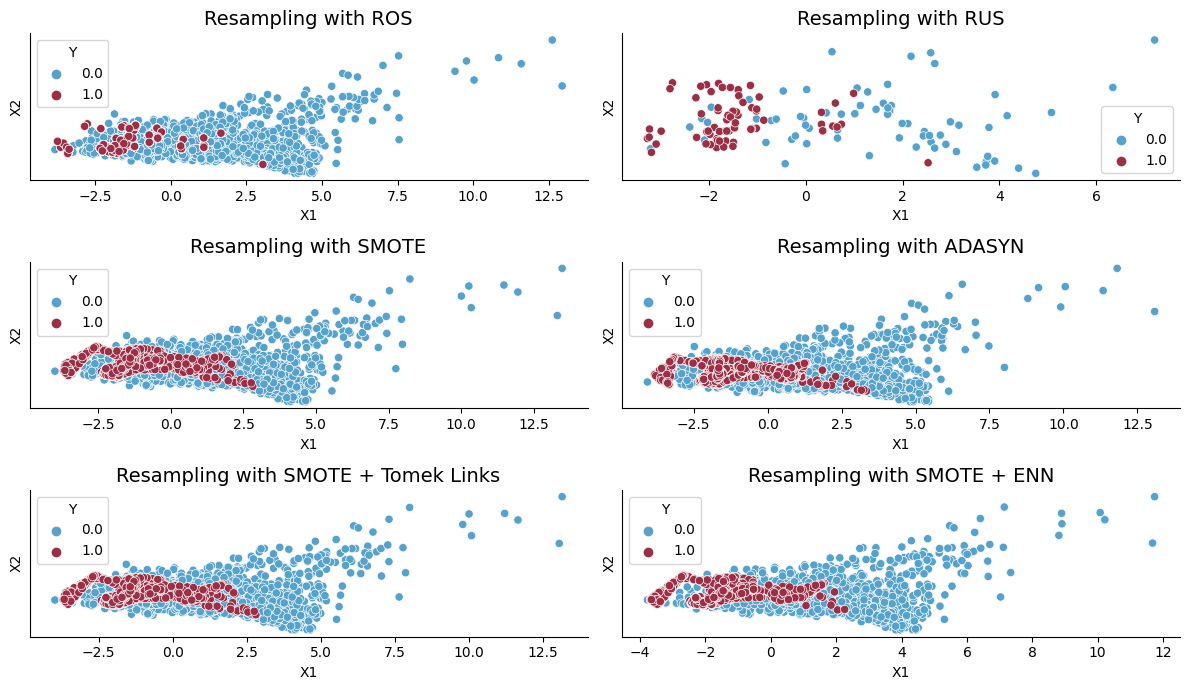

In [32]:
f, axes = plt.subplots(3,2,figsize=(12, 7), dpi=100)
sns.despine()
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_ros, ax=axes[0,0])
axes[0,0].set_title('Resampling with ROS', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_rus, ax=axes[0,1])
axes[0,1].set_title('Resampling with RUS', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_sm, ax=axes[1,0])
axes[1,0].set_title('Resampling with SMOTE', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_ada, ax=axes[1,1])
axes[1,1].set_title('Resampling with ADASYN', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_smtom, ax=axes[2,0])
axes[2,0].set_title('Resampling with SMOTE + Tomek Links', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_smenn, ax=axes[2,1])
axes[2,1].set_title('Resampling with SMOTE + ENN', fontsize=14)
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

### **Feature Selection**

There are mainly three major ways to make feature selection :


*   **Filter methods** : considers the relationship between features and the target variable based on a certain metric to compute the importance of features. 
*   **Wrapper methods** : generate models with a subsets of feature and gauge their model performances. It will lead to a set of features which gives the best performance.
*   **Embedded methods** : use some model algorithms to built the feature selection. For instance, Lasso and RF have their own feature selection methods.

##### 1.   Filter methods




In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler

In [34]:
Y = data['target']
X = data.drop(['target','lat', 'lon', 'payment_id'], axis=1)
X_norm = MinMaxScaler().fit_transform(X)

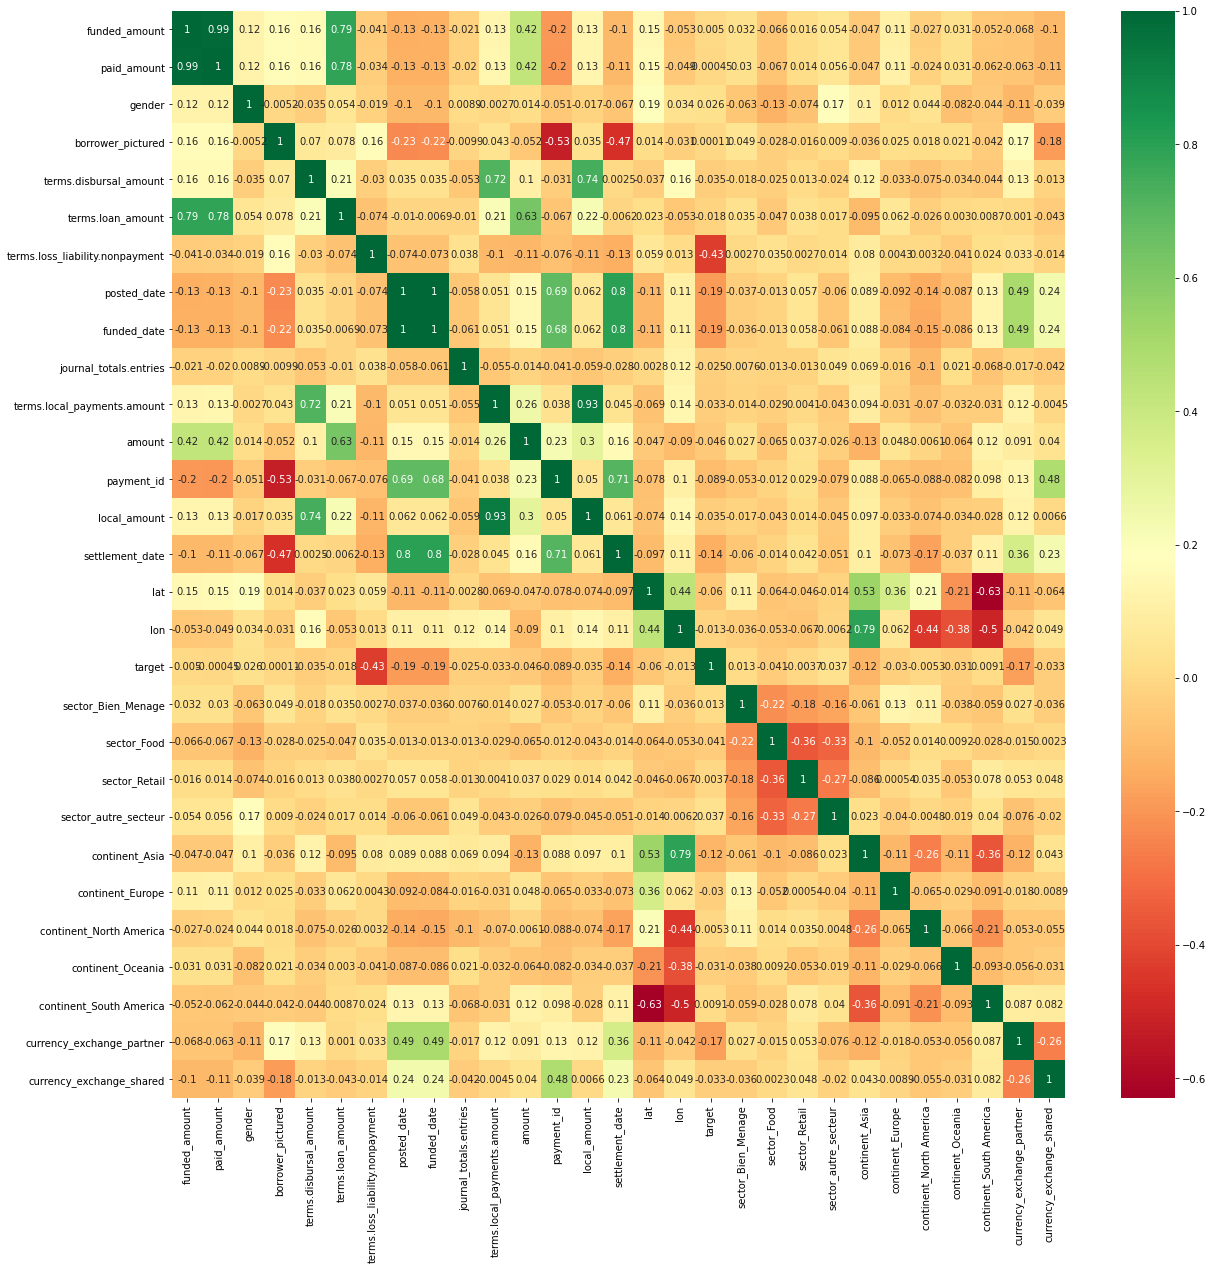

In [35]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [36]:
### First we define the number of features we want to keep
num_feat = 10

In [37]:
#apply SelectKBest class to extract best features
bestfeatures = SelectKBest(score_func=chi2, k=num_feat)
fit = bestfeatures.fit(X_norm,Y)
chi_support = bestfeatures.get_support()
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(num_feat,'Score'))  #print num_feat best features

                              Specs      Score
6   terms.loss_liability.nonpayment  65.092491
23        currency_exchange_partner  31.722585
18                   continent_Asia  29.906145
7                       posted_date  12.387610
8                       funded_date   6.277839
15                      sector_Food   3.728286
17             sector_autre_secteur   3.436505
24         currency_exchange_shared   3.343070
21                continent_Oceania   2.953586
19                 continent_Europe   2.823759


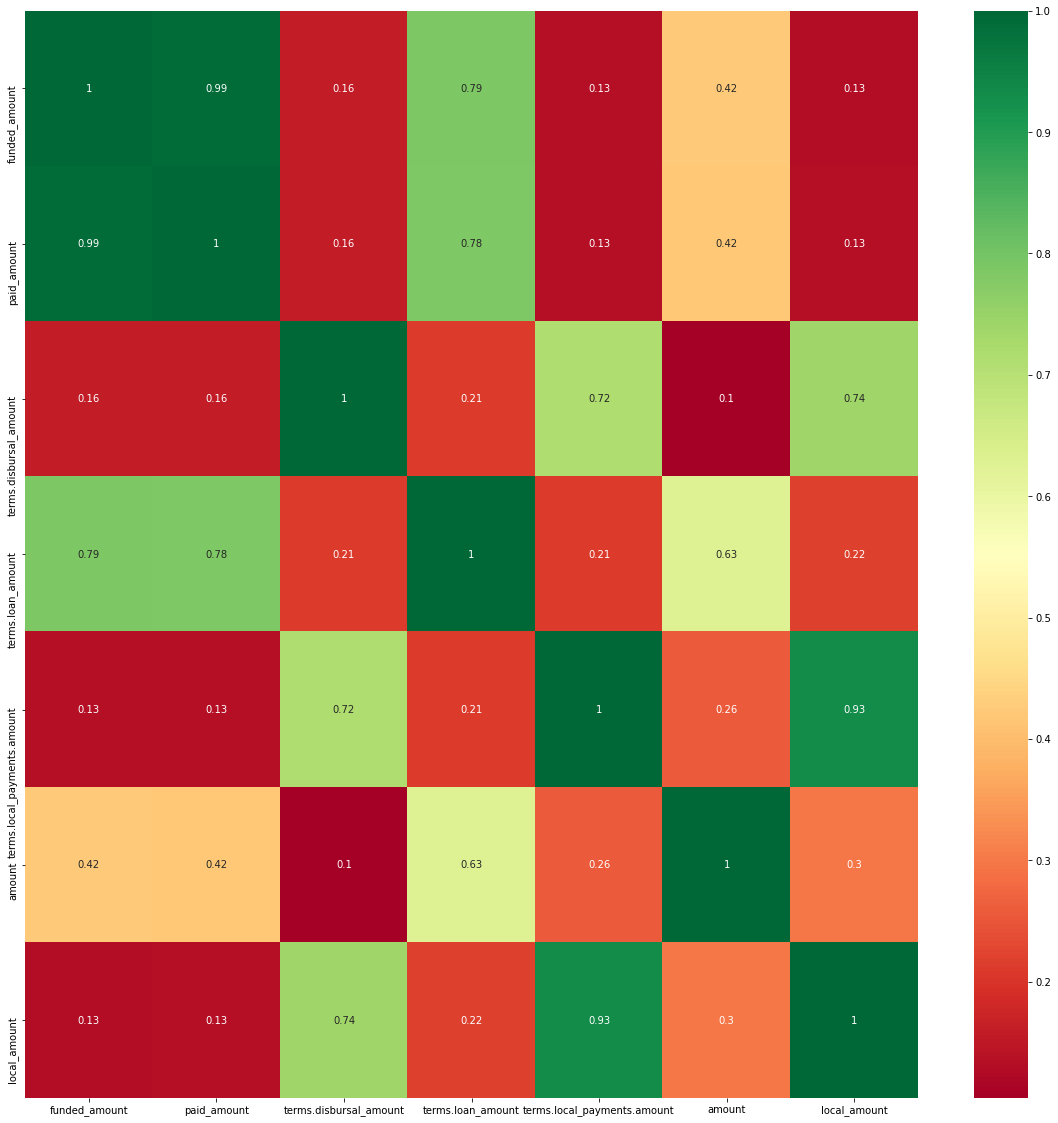

In [38]:
#We verify collinearity between amount variables
amount_columns = data.columns[data.columns.str.contains('amount')]
amount_data = data.filter(items=amount_columns, axis=1)
corrmat = amount_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We remove funded_amount and terms.local_payments.amount due to their strong correlation with another meaningful variables.

In [39]:
# We remove those variables 
X = X.drop(['funded_amount', 'terms.local_payments.amount'], axis=1)
X_norm = MinMaxScaler().fit_transform(X)

In [40]:
fit = bestfeatures.fit(X,Y)
chi_support = bestfeatures.get_support()
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(num_feat,'Score'))  #print num_feat best features

                              Specs         Score
3            terms.disbursal_amount  5.248435e+07
10                     local_amount  7.152681e+06
9                            amount  1.261641e+03
4                 terms.loan_amount  5.210506e+02
5   terms.loss_liability.nonpayment  6.509249e+01
21        currency_exchange_partner  3.172258e+01
16                   continent_Asia  2.990615e+01
13                      sector_Food  3.728286e+00
15             sector_autre_secteur  3.436505e+00
22         currency_exchange_shared  3.343070e+00


##### 2.   Wrapper methods (Recursive Feature Elimination)




In [41]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feat, step=10, verbose=5)
rfe_selector.fit(X_norm, Y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 23 features.
Fitting estimator with 13 features.
10 selected features


##### 3.   Pipeline methods




In [42]:
##Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, Y,num_feat)
##Logistic Regression
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feat)
embeded_lr_selector.fit(X_norm, Y)
embeded_lr_support = embeded_lr_selector.get_support()
##RF
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feat)
embeded_rf_selector.fit(X, Y)
embeded_rf_support = embeded_rf_selector.get_support()
##LGBM
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feat)
embeded_lgb_selector.fit(X, Y)
embeded_lgb_support = embeded_lgb_selector.get_support()

In [43]:
feature_name = X.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feat)

Feature  Pearson  ...  LightGBM  Total
1   terms.loss_liability.nonpayment     True  ...      True      6
2                            amount     True  ...      True      6
3                       posted_date     True  ...      True      5
4            terms.disbursal_amount     True  ...      True      4
5                   settlement_date     True  ...     False      4
6                       funded_date     True  ...      True      4
7         currency_exchange_partner     True  ...     False      4
8                    continent_Asia     True  ...     False      4
9                 terms.loan_amount    False  ...      True      3
10             sector_autre_secteur     True  ...     False      2

[10 rows x 8 columns]

Finally, we retain variables with at least 4 as score. 

In [44]:
var_retain = feature_selection_df[feature_selection_df['Total']>=4]['Feature']

In [45]:
var_retain = var_retain.to_list()

In [46]:
var_retain

['terms.loss_liability.nonpayment',
 'amount',
 'posted_date',
 'terms.disbursal_amount',
 'settlement_date',
 'funded_date',
 'currency_exchange_partner',
 'continent_Asia']

### StandarLized

In [47]:
### Aplly var retain
X_test = X_test[var_retain]
X_train = X_train[var_retain]
X_train_ros = X_train_ros[var_retain]
X_train_rus = X_train_rus[var_retain]
X_train_sm = X_train_sm[var_retain]
X_train_ada = X_train_ada[var_retain]
X_train_smtom = X_train_smtom[var_retain]
X_train_smenn = X_train_smenn[var_retain]

### Apply minmaxscaler
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

X_test = minmax.fit_transform(X_test)
X_train = minmax.fit_transform(X_train)
X_train_ros = minmax.fit_transform(X_train_ros)
X_train_rus = minmax.fit_transform(X_train_rus)
X_train_sm = minmax.fit_transform(X_train_sm)
X_train_ada = minmax.fit_transform(X_train_ada)
X_train_smtom = minmax.fit_transform(X_train_smtom)
X_train_smenn = minmax.fit_transform(X_train_smenn)

In [48]:
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [49]:
def perfomance_measure(model1,algo_name,ishypertuning) :
    # 1 - Imbalance data
    model1.fit(X_train, Y_train)
    y_pred = model1.predict(X_test)
    vec1 = {'Accuracy' : round(100*accuracy_score(Y_test, y_pred),2),'Recall' : round(100*recall_score(Y_test, y_pred),2),
        'Precision' : round(100*precision_score(Y_test, y_pred),2), 'F0.5' : round(100*fbeta_score(Y_test, y_pred, beta=0.5),2) ,'F1' : round(100*f1_score(Y_test, y_pred),2),
        'F2' : round(100*fbeta_score(Y_test, y_pred, beta=2),2), 'G_mean' : round(100*np.sqrt(precision_score(Y_test, y_pred)*recall_score(Y_test, y_pred)),2),
       'AUC' : round(100*roc_auc_score(Y_test, y_pred),2)}

    # 2 - ROS
    model1.fit(X_train_ros, Y_train_ros)
    y_pred = model1.predict(X_test)
    vec2 = {'Accuracy' : round(100*accuracy_score(Y_test, y_pred),2),'Recall' : round(100*recall_score(Y_test, y_pred),2),
        'Precision' : round(100*precision_score(Y_test, y_pred),2), 'F0.5' : round(100*fbeta_score(Y_test, y_pred, beta=0.5),2) ,'F1' : round(100*f1_score(Y_test, y_pred),2),
        'F2' : round(100*fbeta_score(Y_test, y_pred, beta=2),2), 'G_mean' : round(100*np.sqrt(precision_score(Y_test, y_pred)*recall_score(Y_test, y_pred)),2),
       'AUC' : round(100*roc_auc_score(Y_test, y_pred),2)}

    # 3 - RUS
    model1.fit(X_train_rus, Y_train_rus)
    y_pred = model1.predict(X_test)
    vec3 = {'Accuracy' : round(100*accuracy_score(Y_test, y_pred),2),'Recall' : round(100*recall_score(Y_test, y_pred),2),
        'Precision' : round(100*precision_score(Y_test, y_pred),2), 'F0.5' : round(100*fbeta_score(Y_test, y_pred, beta=0.5),2) ,'F1' : round(100*f1_score(Y_test, y_pred),2),
        'F2' : round(100*fbeta_score(Y_test, y_pred, beta=2),2), 'G_mean' : round(100*np.sqrt(precision_score(Y_test, y_pred)*recall_score(Y_test, y_pred)),2),
       'AUC' : round(100*roc_auc_score(Y_test, y_pred),2)}

    # 4 - SMOTE
    model1.fit(X_train_sm, Y_train_sm)
    y_pred = model1.predict(X_test)
    vec4 = {'Accuracy' : round(100*accuracy_score(Y_test, y_pred),2),'Recall' : round(100*recall_score(Y_test, y_pred),2),
        'Precision' : round(100*precision_score(Y_test, y_pred),2), 'F0.5' : round(100*fbeta_score(Y_test, y_pred, beta=0.5),2) ,'F1' : round(100*f1_score(Y_test, y_pred),2),
        'F2' : round(100*fbeta_score(Y_test, y_pred, beta=2),2), 'G_mean' : round(100*np.sqrt(precision_score(Y_test, y_pred)*recall_score(Y_test, y_pred)),2),
       'AUC' : round(100*roc_auc_score(Y_test, y_pred),2)}

    # 5 - ADASYN
    model1.fit(X_train_ada, Y_train_ada)
    y_pred = model1.predict(X_test)
    vec5 = {'Accuracy' : round(100*accuracy_score(Y_test, y_pred),2),'Recall' : round(100*recall_score(Y_test, y_pred),2),
        'Precision' : round(100*precision_score(Y_test, y_pred),2), 'F0.5' : round(100*fbeta_score(Y_test, y_pred, beta=0.5),2) ,'F1' : round(100*f1_score(Y_test, y_pred),2),
        'F2' : round(100*fbeta_score(Y_test, y_pred, beta=2),2), 'G_mean' : round(100*np.sqrt(precision_score(Y_test, y_pred)*recall_score(Y_test, y_pred)),2),
       'AUC' : round(100*roc_auc_score(Y_test, y_pred),2)}
    
    # 6 - SMOTE + TOMEK
    model1.fit(X_train_smtom, Y_train_smtom)
    y_pred = model1.predict(X_test)
    vec6 = {'Accuracy' : round(100*accuracy_score(Y_test, y_pred),2),'Recall' : round(100*recall_score(Y_test, y_pred),2),
        'Precision' : round(100*precision_score(Y_test, y_pred),2), 'F0.5' : round(100*fbeta_score(Y_test, y_pred, beta=0.5),2) ,'F1' : round(100*f1_score(Y_test, y_pred),2),
        'F2' : round(100*fbeta_score(Y_test, y_pred, beta=2),2), 'G_mean' : round(100*np.sqrt(precision_score(Y_test, y_pred)*recall_score(Y_test, y_pred)),2),
       'AUC' : round(100*roc_auc_score(Y_test, y_pred),2)}

    # 7 - SMOTE + ENN
    model1.fit(X_train_smenn, Y_train_smenn)
    y_pred = model1.predict(X_test)
    vec7 = {'Accuracy' : round(100*accuracy_score(Y_test, y_pred),2),'Recall' : round(100*recall_score(Y_test, y_pred),2),
        'Precision' : round(100*precision_score(Y_test, y_pred),2), 'F0.5' : round(100*fbeta_score(Y_test, y_pred, beta=0.5),2) ,'F1' : round(100*f1_score(Y_test, y_pred),2),
        'F2' : round(100*fbeta_score(Y_test, y_pred, beta=2),2), 'G_mean' : round(100*np.sqrt(precision_score(Y_test, y_pred)*recall_score(Y_test, y_pred)),2),
       'AUC' : round(100*roc_auc_score(Y_test, y_pred),2)}

    ##### Return the data
    data_m = [vec1,vec2,vec3,vec4,vec5,vec6,vec7]
    df_measure = pd.DataFrame(data_m,index =['No resampling', 'RoS','RuS','SMOTE','ADASYN','SMOTE + TOMEK','SMOTE + ENN'])
    df_measure.reset_index(inplace = True)
    df_measure = df_measure.rename(columns = {'index':'Technique_inbalance'})
    df_measure['algorithm'] = algo_name
    df_measure['hyperpara'] = ishypertuning
    
    return df_measure

## Regression logistique

In [50]:
# Define model without tuning
lr =LogisticRegression(random_state = 42)

df_lr1 = perfomance_measure(lr,'Logistic Regression','No')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [51]:
# Define model with tuning(GriidSearch)
log_model = LogisticRegression(random_state = 42)

params = {'C':np.logspace(-10, 1, 15),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Create grid search using 5-fold cross validation
clf_lr = GridSearchCV(log_model, params, cv=cv, scoring='roc_auc', n_jobs=-1)

df_lr2 = perfomance_measure(clf_lr,'Logistic Regression','Yes')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [52]:
df_lr = pd.concat([df_lr1,df_lr2])
df_lr.reset_index(drop = True,inplace = True)
df_lr

Technique_inbalance  Accuracy  Recall  ...    AUC            algorithm  hyperpara
0        No resampling     98.53   70.00  ...  84.73  Logistic Regression         No
1                  RoS     93.40   83.33  ...  88.53  Logistic Regression         No
2                  RuS     91.20   83.33  ...  87.40  Logistic Regression         No
3                SMOTE     93.40   83.33  ...  88.53  Logistic Regression         No
4               ADASYN     92.77   83.33  ...  88.21  Logistic Regression         No
5        SMOTE + TOMEK     92.88   83.33  ...  88.26  Logistic Regression         No
6          SMOTE + ENN     91.73   83.33  ...  87.67  Logistic Regression         No
7        No resampling     93.61   83.33  ...  88.64  Logistic Regression        Yes
8                  RoS     93.72   83.33  ...  88.69  Logistic Regression        Yes
9                  RuS     91.20   83.33  ...  87.40  Logistic Regression        Yes
10               SMOTE     93.51   83.33  ...  88.59  Logistic Regression        Yes
11              ADASYN     93.30   83.33  ...  88.48  Logistic Regression        Yes
12       SMOTE + TOMEK     93.30   83.33  ...  88.48  Logistic Regression        Yes
13         SMOTE + ENN     91.83   83.33  ...  87.72  Logistic Regression        Yes

[14 rows x 11 columns]

## Decision tree

In [53]:
# Model without tuning
dt = DecisionTreeClassifier(random_state = 42)

df_dt1 = perfomance_measure(dt,'Decision Tree','No')

In [54]:
# Model with tuning
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

tree_model = DecisionTreeClassifier(random_state = 42)

tree_param_grid = { 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
df_dt2 = perfomance_measure(clf_DT,'Decision Tree','Yes')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


In [55]:
df_dt = pd.concat([df_dt1,df_dt2])
df_dt.reset_index(drop = True,inplace = True)
df_dt

Technique_inbalance  Accuracy  Recall  ...    AUC      algorithm  hyperpara
0        No resampling     97.17   43.33  ...  71.13  Decision Tree         No
1                  RoS     96.54   20.00  ...  59.51  Decision Tree         No
2                  RuS     86.07   83.33  ...  84.75  Decision Tree         No
3                SMOTE     95.81   33.33  ...  65.59  Decision Tree         No
4               ADASYN     96.34   50.00  ...  73.92  Decision Tree         No
5        SMOTE + TOMEK     96.23   50.00  ...  73.86  Decision Tree         No
6          SMOTE + ENN     95.71   33.33  ...  65.53  Decision Tree         No
7        No resampling     97.28   66.67  ...  82.47  Decision Tree        Yes
8                  RoS     96.34   73.33  ...  85.21  Decision Tree        Yes
9                  RuS     86.18   83.33  ...  84.80  Decision Tree        Yes
10               SMOTE     95.92   56.67  ...  76.93  Decision Tree        Yes
11              ADASYN     95.18   50.00  ...  73.32  Decision Tree        Yes
12       SMOTE + TOMEK     95.92   56.67  ...  76.93  Decision Tree        Yes
13         SMOTE + ENN     95.92   83.33  ...  89.83  Decision Tree        Yes

[14 rows x 11 columns]

## XGBoost 

In [56]:
# Model without tuning
xgb_class = xgb.XGBClassifier(random_state = 42 )

df_xgb1 = perfomance_measure(xgb_class,'XGBoost','No')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [57]:
xgb_hyp = xgb.XGBClassifier(random_seed=42)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

clf_xgb = grid_search = GridSearchCV(
    estimator=xgb_hyp,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)
df_xgb2 = perfomance_measure(clf_xgb,'XGBoost','Yes')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   23.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   48.9s
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:   55.8s finished


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:   41.3s
[Parallel(n_jobs=10)]: Done 450 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:  1.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:    8.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   44.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:  2.0min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   44.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:  2.1min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   43.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:  2.0min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:   38.2s
[Parallel(n_jobs=10)]: Done 450 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:  1.6min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
df_xgb = pd.concat([df_xgb1,df_xgb2])
df_xgb.reset_index(drop = True,inplace = True)
df_xgb

Technique_inbalance  Accuracy  Recall  ...    AUC  algorithm  hyperpara
0        No resampling     98.32   56.67  ...  78.17    XGBoost         No
1                  RoS     96.54   80.00  ...  88.54    XGBoost         No
2                  RuS     87.85   83.33  ...  85.67    XGBoost         No
3                SMOTE     96.02   73.33  ...  85.05    XGBoost         No
4               ADASYN     96.34   73.33  ...  85.21    XGBoost         No
5        SMOTE + TOMEK     95.81   73.33  ...  84.94    XGBoost         No
6          SMOTE + ENN     95.71   80.00  ...  88.11    XGBoost         No
7        No resampling     97.70   46.67  ...  73.01    XGBoost        Yes
8                  RoS     97.59   53.33  ...  76.18    XGBoost        Yes
9                  RuS     89.84   83.33  ...  86.69    XGBoost        Yes
10               SMOTE     95.92   53.33  ...  75.32    XGBoost        Yes
11              ADASYN     95.92   53.33  ...  75.32    XGBoost        Yes
12       SMOTE + TOMEK     96.23   56.67  ...  77.09    XGBoost        Yes
13         SMOTE + ENN     96.54   73.33  ...  85.32    XGBoost        Yes

[14 rows x 11 columns]

## Super Vector Machine (SVM)

In [59]:
# Model without tuning
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 42)

df_svm1 = perfomance_measure(svm,'SVM','No')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [60]:
# Model with tuning
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = 5)
df_svm2 = perfomance_measure(svm_grid,'SVM','Yes')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.993, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.982, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.975, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.980, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.980, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.969, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.969, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.969, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.969, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.969, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.969, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.969, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.969, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.933, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.948, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.928, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.932, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.906, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.904, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.918, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.908, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.900, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.883, total=   0.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.910, total=   0.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.920, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.908, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.908, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.883, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.499, total=   0.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.499, total=   0.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.841, total=   0.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.845, total=   0.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.804, total=   0.7s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.7s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.841, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.845, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.804, total=   0.6s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.936, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=1, gamma=1, kernel=rbf, score=0.950, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.937, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=1, gamma=1, kernel=rbf, score=0.934, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.910, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.932, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.946, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.928, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.926, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.908, total=   0.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.895, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.910, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.900, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.891, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.871, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.910, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.920, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.908, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.908, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.883, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.7s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.841, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.845, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.804, total=   0.6s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.936, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.950, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.937, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.934, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.910, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.936, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.950, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.934, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.933, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.910, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.911, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.922, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.911, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.911, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.884, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.895, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.910, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.900, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.891, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.871, total=   0.2s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.910, total=   0.4s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.920, total=   0.4s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.908, total=   0.4s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.907, total=   0.4s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.883, total=   0.4s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.936, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=100, gamma=1, kernel=rbf, score=0.950, total=   0.2s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.937, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=100, gamma=1, kernel=rbf, score=0.934, total=   0.2s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.910, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.936, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.950, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.937, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.934, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.910, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.932, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.948, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.933, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.932, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.908, total=   0.1s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.907, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.918, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.903, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.905, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.877, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.895, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.910, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.900, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.891, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.871, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.940, total=   0.3s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.955, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.942, total=   0.3s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.935, total=   0.5s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.910, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.936, total=   0.3s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.950, total=   0.3s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.937, total=   0.3s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.934, total=   0.3s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.910, total=   0.3s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.935, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.949, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.934, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.933, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.908, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.912, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.925, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.915, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.912, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.889, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.907, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.918, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.903, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.905, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.877, total=   0.2s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   33.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.893, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.893, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.893, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.821, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.964, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

[CV] ........... C=10, gamma=1, kernel=rbf, score=0.893, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.893, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.929, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.857, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.893, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.857, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.893, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.929, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.821, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.964, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.893, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.893, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.857, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.934, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.940, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.942, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.933, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.940, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.906, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.907, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.913, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.905, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.911, total=   0.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.906, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.905, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.911, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.905, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.908, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.499, total=   0.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.499, total=   0.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.846, total=   0.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.842, total=   0.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.831, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.846, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.842, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.831, total=   0.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.941, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=1, gamma=1, kernel=rbf, score=0.943, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.948, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=1, gamma=1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.950, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.933, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.933, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.933, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.929, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.936, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.892, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.896, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.905, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.887, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.898, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.906, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.905, total=   0.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.911, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.905, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.908, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.846, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.842, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.831, total=   0.6s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.944, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.943, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.949, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.951, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.936, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.941, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.944, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.934, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.944, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.908, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.908, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.914, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.907, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.911, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.892, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.896, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.904, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.887, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.898, total=   0.2s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.906, total=   0.5s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.905, total=   0.5s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.911, total=   0.5s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.905, total=   0.5s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.908, total=   0.5s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.947, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=100, gamma=1, kernel=rbf, score=0.946, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.951, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=100, gamma=1, kernel=rbf, score=0.940, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.954, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.941, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.943, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.948, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.950, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.930, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.935, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.937, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.929, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.936, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.905, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.905, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.910, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.904, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.908, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.892, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.896, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.904, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.887, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.898, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.951, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.950, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.958, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.944, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.959, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.944, total=   0.3s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.944, total=   0.3s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.950, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.939, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.951, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.936, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.941, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.944, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.934, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.944, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.911, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.911, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.919, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.908, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.915, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.905, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.905, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.910, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.904, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   33.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.908, total=   0.2s
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.984, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.906, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.906, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.885, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.929, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.955, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.876, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.878, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.863, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.897, total=   0.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.961, total=   0.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.874, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.877, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.863, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.892, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.499, total=   0.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.808, total=   0.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.810, total=   0.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.500, total=   0.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.500, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.808, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.810, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.500, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.500, total=   0.6s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.987, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=1, gamma=1, kernel=rbf, score=0.913, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.911, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=1, gamma=1, kernel=rbf, score=0.920, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.936, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.983, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.903, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.904, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.890, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.922, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.946, total=   0.3s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.864, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.869, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.847, total=   0.3s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.885, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.958, total=   0.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.874, total=   0.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.877, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.863, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.892, total=   0.5s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.499, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.808, total=   0.7s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.810, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.500, total=   0.7s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.500, total=   0.6s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.987, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.917, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.911, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.929, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.984, total=   0.2s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.908, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.907, total=   0.2s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.912, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.934, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.962, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.877, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.879, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.852, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.898, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.946, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.864, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.869, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.847, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.885, total=   0.2s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.957, total=   0.5s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.874, total=   0.5s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.877, total=   0.5s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.863, total=   0.5s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.892, total=   0.5s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.987, total=   0.2s
[CV] C=100, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=100, gamma=1, kernel=rbf, score=0.917, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.912, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=100, gamma=1, kernel=rbf, score=0.933, total=   0.2s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.987, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.914, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.911, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.923, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.939, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.983, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.903, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.903, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.890, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.926, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.962, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.876, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.878, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.847, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.898, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.946, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.864, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.869, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.847, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.885, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.987, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.918, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.912, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.934, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.987, total=   0.3s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.917, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.911, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.930, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.939, total=   0.3s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.983, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.908, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.907, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.912, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.934, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.963, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.879, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.882, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.855, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.903, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.962, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.876, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.878, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.840, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   34.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.898, total=   0.2s
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.931, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.940, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.942, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.932, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.905, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.907, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.913, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.904, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.910, total=   0.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.905, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.905, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.911, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.904, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.907, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.830, total=   0.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.844, total=   0.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.854, total=   0.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.843, total=   0.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.835, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.830, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.844, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.854, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.843, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.835, total=   0.6s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.943, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=1, gamma=1, kernel=rbf, score=0.948, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=1, gamma=1, kernel=rbf, score=0.950, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.930, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.933, total=   0.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.933, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.929, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.936, total=   0.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.890, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.895, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.905, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.886, total=   0.2s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.896, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.905, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.905, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.911, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.904, total=   0.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.907, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.830, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.844, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.854, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.843, total=   0.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.835, total=   0.6s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.942, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.943, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.949, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.951, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.932, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.940, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.944, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.933, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.942, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.907, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.908, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.913, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.905, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.908, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.890, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.895, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.904, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.886, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.896, total=   0.2s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.905, total=   0.4s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.905, total=   0.4s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.911, total=   0.4s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.904, total=   0.4s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.907, total=   0.4s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.944, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=100, gamma=1, kernel=rbf, score=0.945, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.951, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=100, gamma=1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.954, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.938, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.943, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.948, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.950, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.929, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.936, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.938, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.929, total=   0.2s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.936, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.904, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.906, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.910, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.902, total=   0.2s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.907, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.890, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.895, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.904, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.886, total=   0.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.896, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.949, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.950, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.958, total=   0.1s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.944, total=   0.2s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.960, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.942, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.944, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.950, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.938, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.951, total=   0.3s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.933, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.942, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.944, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.933, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.944, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.913, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.914, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.920, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.907, total=   0.2s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.917, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.904, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.906, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.910, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.901, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.907, total=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   31.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.932, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.945, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.944, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.903, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.903, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.913, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.907, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.914, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.911, total=   0.3s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.911, total=   0.3s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.918, total=   0.3s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.914, total=   0.3s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.920, total=   0.3s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.942, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=1, gamma=1, kernel=rbf, score=0.952, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.944, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.953, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.930, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.935, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.944, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.934, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.941, total=   0.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.904, total=   0.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.901, total=   0.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.911, total=   0.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.906, total=   0.1s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.913, total=   0.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.911, total=   0.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.911, total=   0.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.918, total=   0.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.914, total=   0.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.920, total=   0.3s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.520, total=   0.4s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.942, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.952, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.945, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.953, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.932, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.939, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.949, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.946, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.923, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.914, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.915, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.911, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.932, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.904, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.901, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.911, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.903, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.913, total=   0.1s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.911, total=   0.3s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.911, total=   0.3s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.918, total=   0.3s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.914, total=   0.3s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.920, total=   0.3s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.942, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.944, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .......... C=100, gamma=1, kernel=rbf, score=0.953, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.945, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.956, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.938, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.942, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.952, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.945, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.953, total=   0.1s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.930, total=   0.1s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.935, total=   0.1s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.942, total=   0.1s
[CV] C=100, gamma=0.01, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.934, total=   0.1s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=100, gamma=0.01, kernel=rbf, score=0.941, total=   0.1s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.903, total=   0.1s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.903, total=   0.1s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.913, total=   0.1s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.908, total=   0.1s
[CV] C=100, gamma=0.001, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.914, total=   0.1s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.904, total=   0.1s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.901, total=   0.1s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.911, total=   0.1s
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.903, total=   0.1s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.913, total=   0.1s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.945, total=   0.1s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.945, total=   0.1s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.958, total=   0.1s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.946, total=   0.1s
[CV] C=1000, gamma=1, kernel=rbf .....................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.959, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.941, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.942, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.953, total=   0.2s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.945, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.955, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.931, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.939, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.949, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.938, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.946, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.911, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.921, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.931, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.927, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.920, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.903, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.903, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.911, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.907, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.911, total=   0.1s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   21.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
df_svm = pd.concat([df_svm1,df_svm2])
df_svm.reset_index(drop = True,inplace = True)
df_svm

Technique_inbalance  Accuracy  Recall  ...    AUC  algorithm  hyperpara
0        No resampling     98.32   73.33  ...  86.23        SVM         No
1                  RoS     98.43   76.67  ...  87.90        SVM         No
2                  RuS     96.96   83.33  ...  90.37        SVM         No
3                SMOTE     98.43   76.67  ...  87.90        SVM         No
4               ADASYN     98.43   76.67  ...  87.90        SVM         No
5        SMOTE + TOMEK     98.43   76.67  ...  87.90        SVM         No
6          SMOTE + ENN     98.43   76.67  ...  87.90        SVM         No
7        No resampling     98.32   73.33  ...  86.23        SVM        Yes
8                  RoS     98.22   76.67  ...  87.79        SVM        Yes
9                  RuS     96.44   83.33  ...  90.10        SVM        Yes
10               SMOTE     98.43   73.33  ...  86.29        SVM        Yes
11              ADASYN     98.43   73.33  ...  86.29        SVM        Yes
12       SMOTE + TOMEK     98.43   73.33  ...  86.29        SVM        Yes
13         SMOTE + ENN     98.43   73.33  ...  86.29        SVM        Yes

[14 rows x 11 columns]

## Random forest 

In [62]:
# Model without tuning
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

df_rf1 = perfomance_measure(forest_clf,'Random Forest','No')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4

In [63]:
# Model with tuning
clf_dt = RandomForestClassifier()
param_grid = {
   'max_leaf_nodes': [  10,20,30,40,50 ],
   'class_weight' : ['balanced'],
   'criterion' :['gini','entropy'] ,
   'max_depth' : [ 30, 20, 75, 50, 100 ],
    }

CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
df_rf2 = perfomance_measure(CV_dt,'Random Forest','Yes')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

In [64]:
df_rf = pd.concat([df_rf1,df_rf2])
df_rf.reset_index(drop = True,inplace = True)
df_rf

Technique_inbalance  Accuracy  Recall  ...    AUC      algorithm  hyperpara
0        No resampling     97.70   43.33  ...  71.40  Random Forest         No
1                  RoS     97.59   33.33  ...  66.50  Random Forest         No
2                  RuS     93.82   83.33  ...  88.75  Random Forest         No
3                SMOTE     96.13   50.00  ...  73.81  Random Forest         No
4               ADASYN     96.02   50.00  ...  73.76  Random Forest         No
5        SMOTE + TOMEK     95.92   50.00  ...  73.70  Random Forest         No
6          SMOTE + ENN     96.23   56.67  ...  77.09  Random Forest         No
7        No resampling     98.32   60.00  ...  79.78  Random Forest        Yes
8                  RoS     97.91   50.00  ...  74.73  Random Forest        Yes
9                  RuS     93.93   83.33  ...  88.80  Random Forest        Yes
10               SMOTE     96.23   60.00  ...  78.70  Random Forest        Yes
11              ADASYN     96.44   76.67  ...  86.87  Random Forest        Yes
12       SMOTE + TOMEK     96.23   60.00  ...  78.70  Random Forest        Yes
13         SMOTE + ENN     96.75   76.67  ...  87.04  Random Forest        Yes

[14 rows x 11 columns]

## Neural Network Classification

In [65]:
# Model without tuning
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(12,8,1), activation='relu', solver='adam', max_iter=500)
df_nnc1 = perfomance_measure(mlp,'Neural Network','No')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum ite

In [66]:
df_nnc1

Technique_inbalance  Accuracy  Recall  ...    AUC       algorithm  hyperpara
0       No resampling     96.86    0.00  ...  50.00  Neural Network         No
1                 RoS     98.43   76.67  ...  87.90  Neural Network         No
2                 RuS     96.86    0.00  ...  50.00  Neural Network         No
3               SMOTE     98.43   76.67  ...  87.90  Neural Network         No
4              ADASYN     98.43   73.33  ...  86.29  Neural Network         No
5       SMOTE + TOMEK     98.43   76.67  ...  87.90  Neural Network         No
6         SMOTE + ENN     98.53   76.67  ...  87.95  Neural Network         No

[7 rows x 11 columns]

In [67]:
# Model with tuning
from sklearn.model_selection import GridSearchCV
mlp_gs = MLPClassifier(max_iter=500)
param_grid = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, param_grid, n_jobs=-1, cv=3)
df_nnc2 = perfomance_measure(clf,'Neural Network','Yes')

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

In [68]:
df_nnc = pd.concat([df_nnc1,df_nnc2])
df_nnc.reset_index(drop = True,inplace = True)
df_nnc

Technique_inbalance  Accuracy  Recall  ...    AUC       algorithm  hyperpara
0        No resampling     96.86    0.00  ...  50.00  Neural Network         No
1                  RoS     98.43   76.67  ...  87.90  Neural Network         No
2                  RuS     96.86    0.00  ...  50.00  Neural Network         No
3                SMOTE     98.43   76.67  ...  87.90  Neural Network         No
4               ADASYN     98.43   73.33  ...  86.29  Neural Network         No
5        SMOTE + TOMEK     98.43   76.67  ...  87.90  Neural Network         No
6          SMOTE + ENN     98.53   76.67  ...  87.95  Neural Network         No
7        No resampling     98.43   73.33  ...  86.29  Neural Network        Yes
8                  RoS     98.32   73.33  ...  86.23  Neural Network        Yes
9                  RuS     92.98   83.33  ...  88.32  Neural Network        Yes
10               SMOTE     98.43   73.33  ...  86.29  Neural Network        Yes
11              ADASYN     98.43   76.67  ...  87.90  Neural Network        Yes
12       SMOTE + TOMEK     98.43   76.67  ...  87.90  Neural Network        Yes
13         SMOTE + ENN     98.43   76.67  ...  87.90  Neural Network        Yes

[14 rows x 11 columns]

## Combine all algorim

In [69]:
df_measure = pd.concat([df_lr,df_dt,df_xgb,df_svm,df_rf,df_nnc])
df_measure.reset_index(drop = True,inplace = True)
df_measure.head()

Technique_inbalance  Accuracy  Recall  ...    AUC            algorithm  hyperpara
0       No resampling     98.53   70.00  ...  84.73  Logistic Regression         No
1                 RoS     93.40   83.33  ...  88.53  Logistic Regression         No
2                 RuS     91.20   83.33  ...  87.40  Logistic Regression         No
3               SMOTE     93.40   83.33  ...  88.53  Logistic Regression         No
4              ADASYN     92.77   83.33  ...  88.21  Logistic Regression         No

[5 rows x 11 columns]

In [70]:
df_measure = df_measure.reindex(columns=['algorithm','hyperpara','Technique_inbalance','Accuracy','Recall','Precision','F0.5','F1','F2','G_mean','AUC'])
df_measure.head()

algorithm hyperpara Technique_inbalance  ...     F2  G_mean    AUC
0  Logistic Regression        No       No resampling  ...  71.92   75.19  84.73
1  Logistic Regression        No                 RoS  ...  61.58   50.10  88.53
2  Logistic Regression        No                 RuS  ...  55.80   44.76  87.40
3  Logistic Regression        No               SMOTE  ...  61.58   50.10  88.53
4  Logistic Regression        No              ADASYN  ...  59.81   48.38  88.21

[5 rows x 11 columns]

In [71]:
# Save of data
df_measure.to_csv('/content/drive/My Drive/Stat_App/performance_measure.csv',index = False)

In [72]:
# Save of data
df_measure = pd.read_csv('/content/drive/My Drive/Stat_App/performance_measure.csv')

### Best Model according to accuracy

In [73]:
from plotnine import *
import plotnine

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


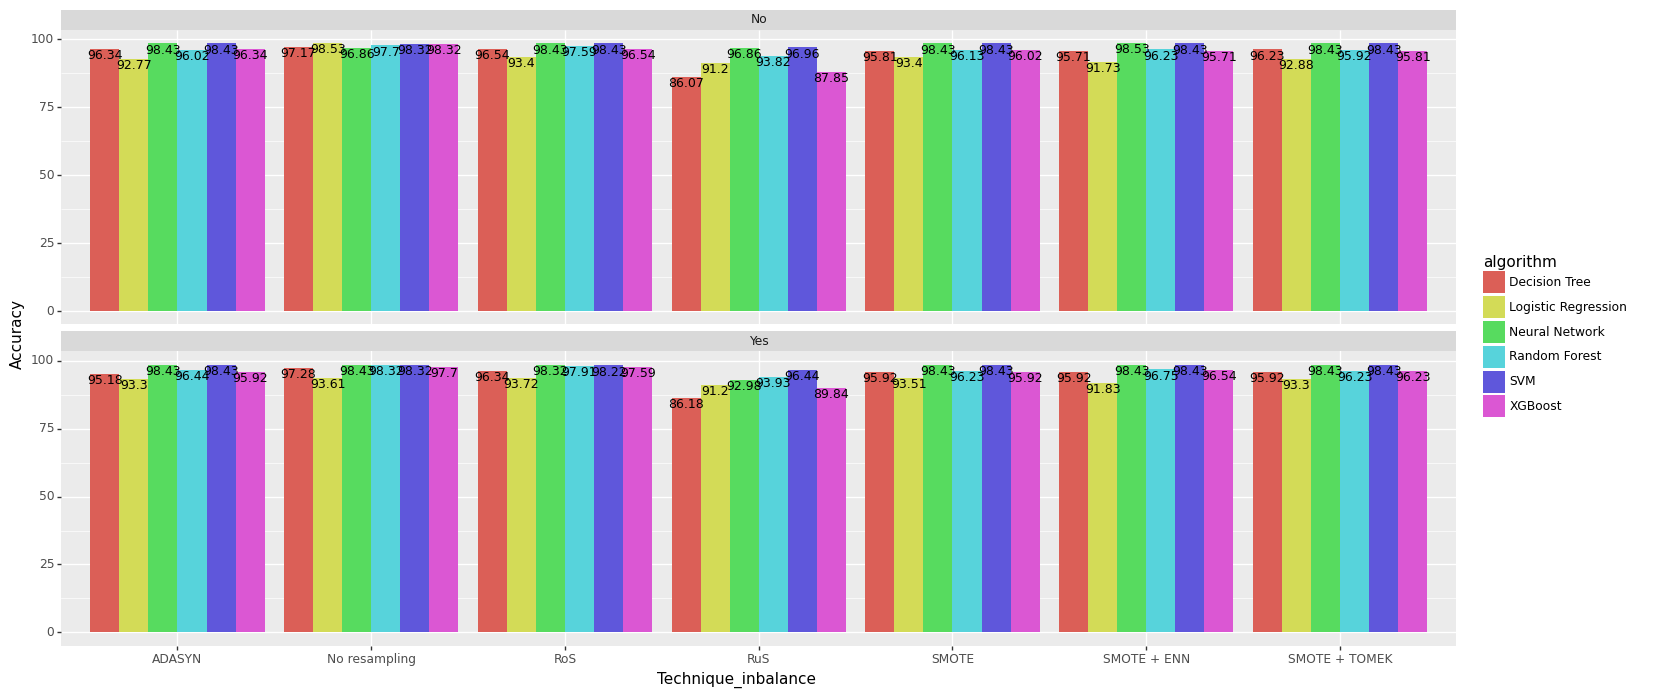

<ggplot: (8761903567397)>

In [74]:
(
   ggplot(data=df_measure)
   + aes(x='Technique_inbalance', y='Accuracy',fill = 'algorithm')
   + geom_bar(stat="identity",position=position_dodge())
   + geom_text(aes(label='Accuracy'), position=position_dodge(width=0.9),size=9,va = 'top')
   + facet_wrap('~hyperpara', dir = "v",nrow = 2)
   + theme(figure_size=(18, 8))  # here you define the plot size
)

Best Model according to recall

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


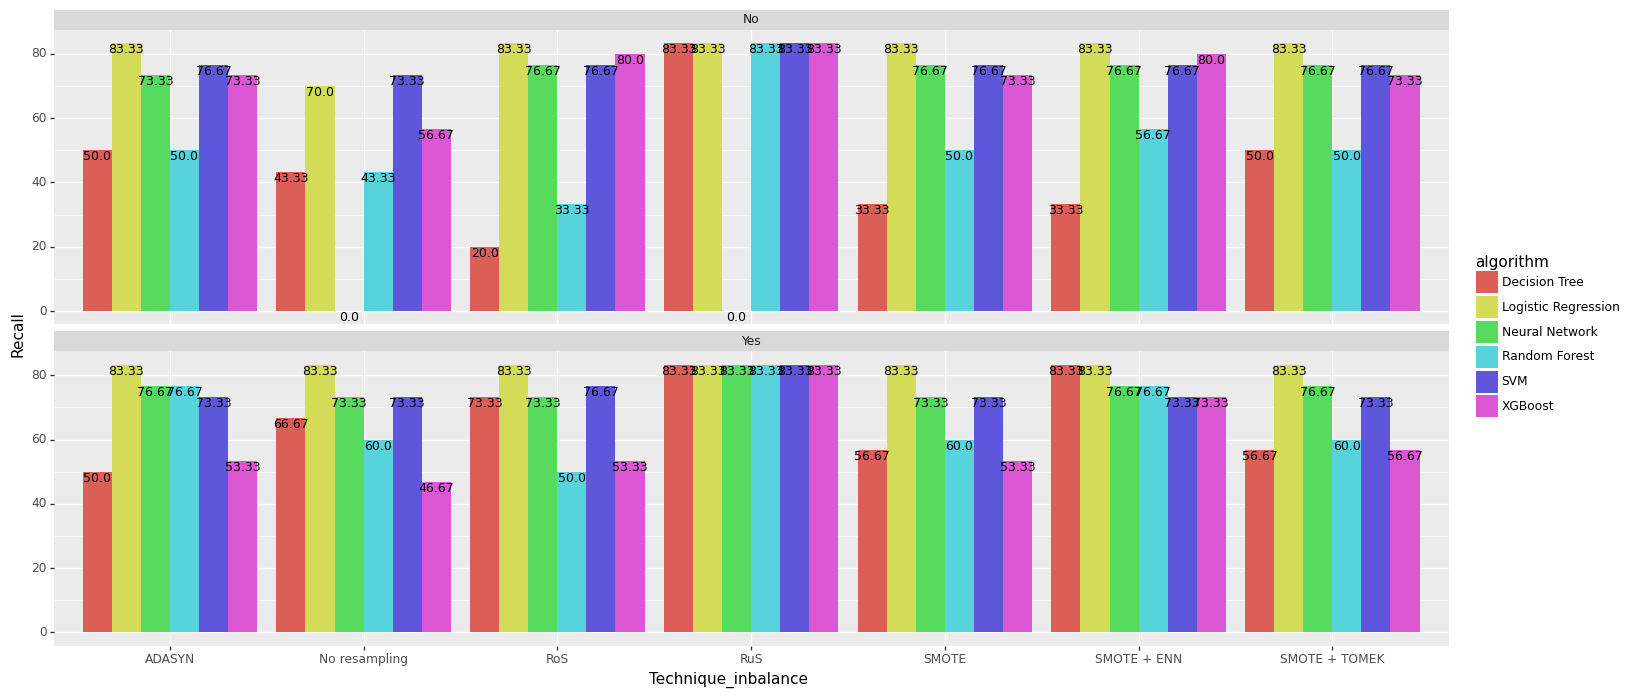

<ggplot: (8761904139541)>

In [75]:
(
   ggplot(data=df_measure)
   + aes(x='Technique_inbalance', y='Recall',fill = 'algorithm')
   + geom_bar(stat="identity",position=position_dodge())
   + geom_text(aes(label='Recall'), position=position_dodge(width=0.9),size=9,va = 'top')
    + facet_wrap('~hyperpara', dir = "v",nrow = 2)
   + theme(figure_size=(18, 8))  # here you define the plot size
)

Best Model according to precision

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


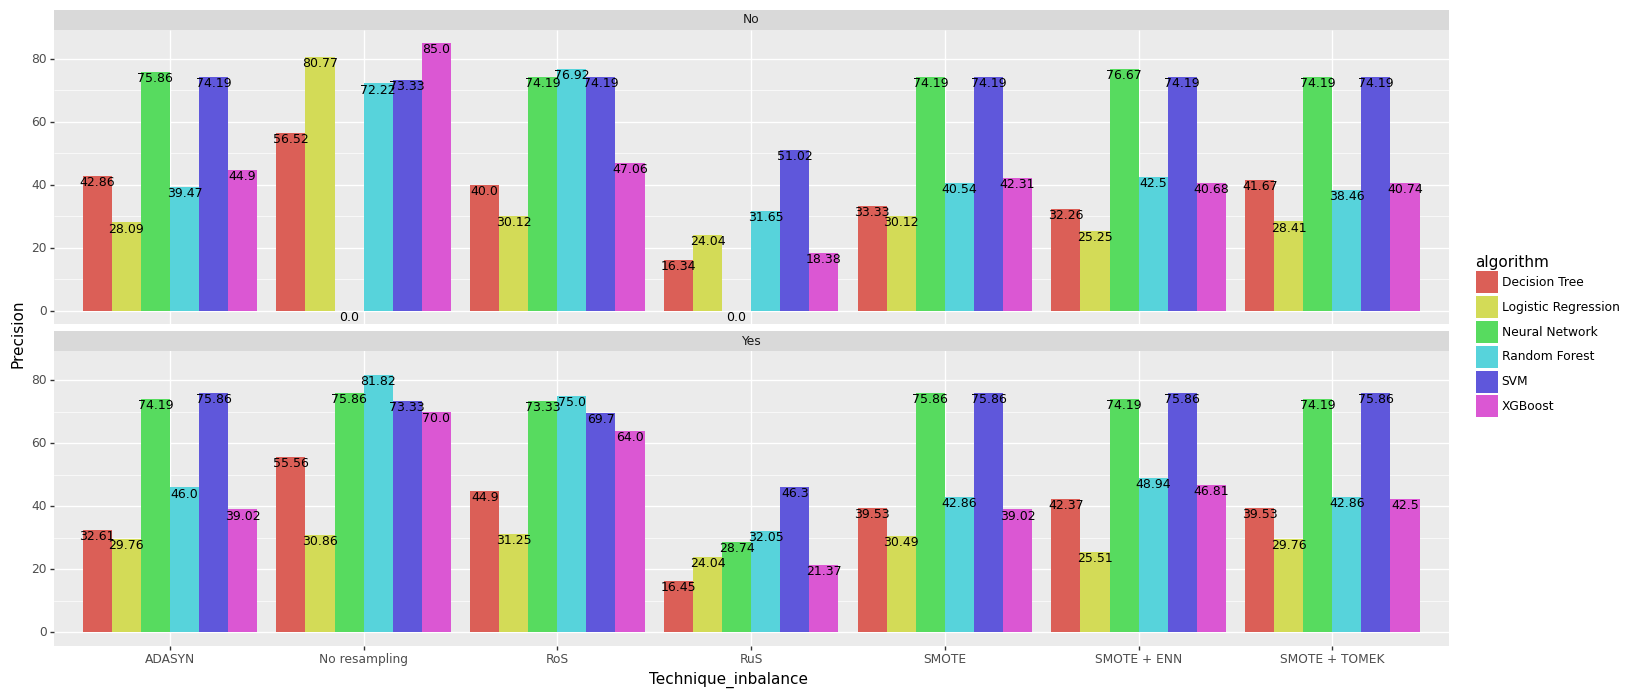

<ggplot: (8761904123985)>

In [76]:
(
   ggplot(data=df_measure)
   + aes(x='Technique_inbalance', y='Precision',fill = 'algorithm')
   + geom_bar(stat="identity",position=position_dodge())
   + geom_text(aes(label='Precision'), position=position_dodge(width=0.9),size=9,va = 'top')
   + facet_wrap('~hyperpara', dir = "v",nrow = 2)
   + theme(figure_size=(18, 8))  # here you define the plot size
)

Best Model according to F1

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


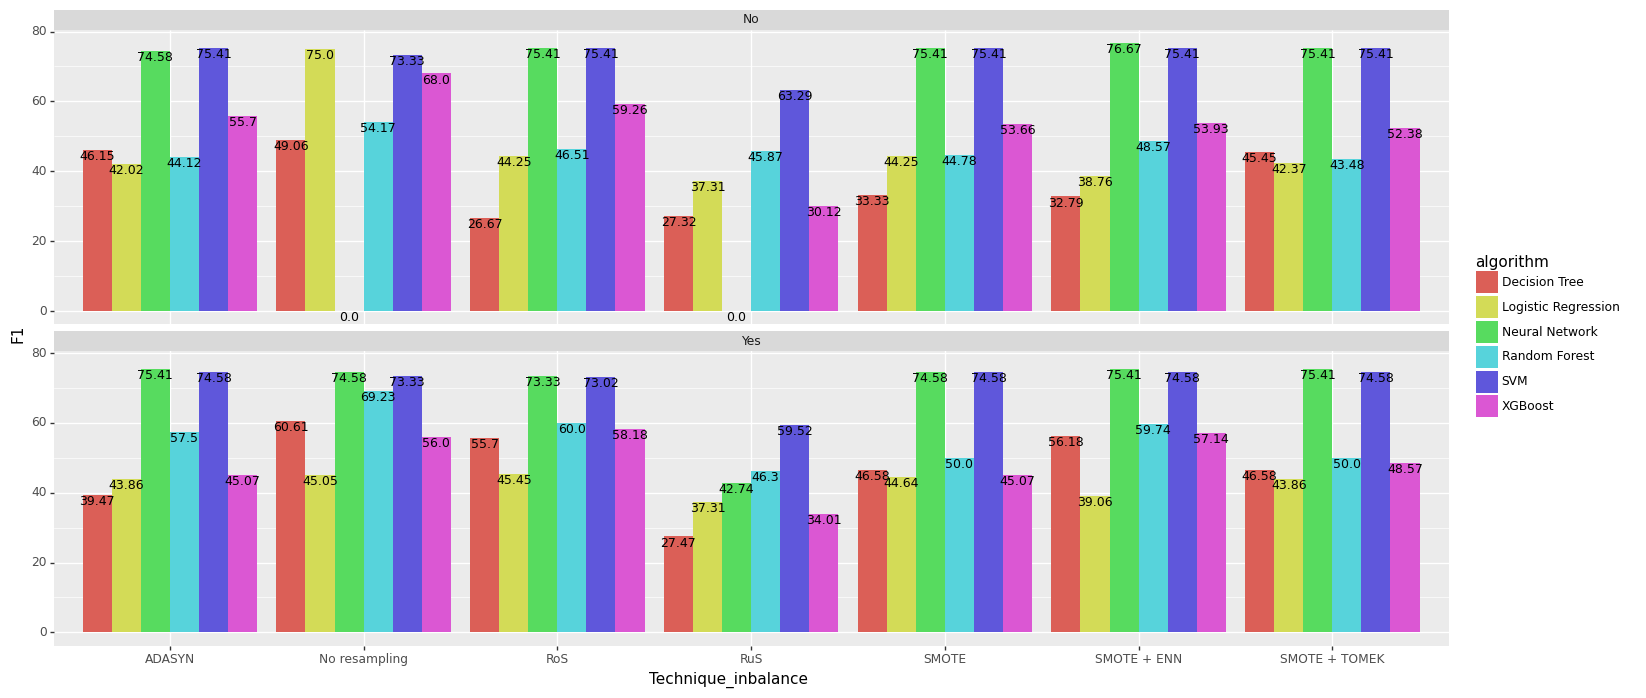

<ggplot: (8761903919789)>

In [77]:
(
   ggplot(data=df_measure)
   + aes(x='Technique_inbalance', y='F1',fill = 'algorithm')
   + geom_bar(stat="identity",position=position_dodge())
   + geom_text(aes(label='F1'), position=position_dodge(width=0.9),size=9,va = 'top')
   + facet_wrap('~hyperpara', dir = "v",nrow = 2)
   + theme(figure_size=(18, 8))  # here you define the plot size
)

Best Model According to F0.5

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


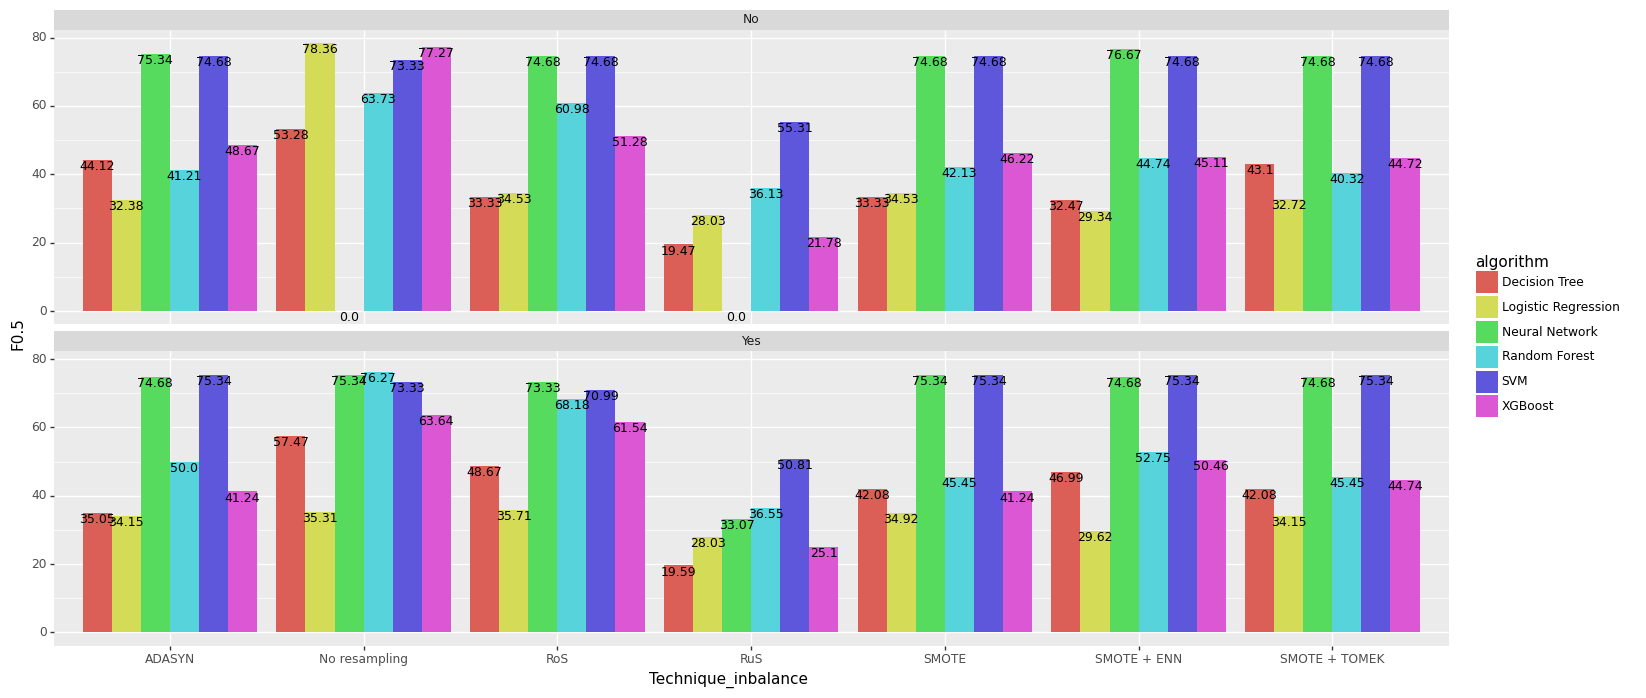

<ggplot: (8761903812841)>

In [78]:
(
   ggplot(data=df_measure)
   + aes(x='Technique_inbalance', y='F0.5',fill = 'algorithm')
   + geom_bar(stat="identity",position=position_dodge())
   + geom_text(aes(label='F0.5'), position=position_dodge(width=0.9),size=9,va = 'top')
   + facet_wrap('~hyperpara', dir = "v",nrow = 2)
   + theme(figure_size=(18, 8))  # here you define the plot size
)

Best Model According to F2

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


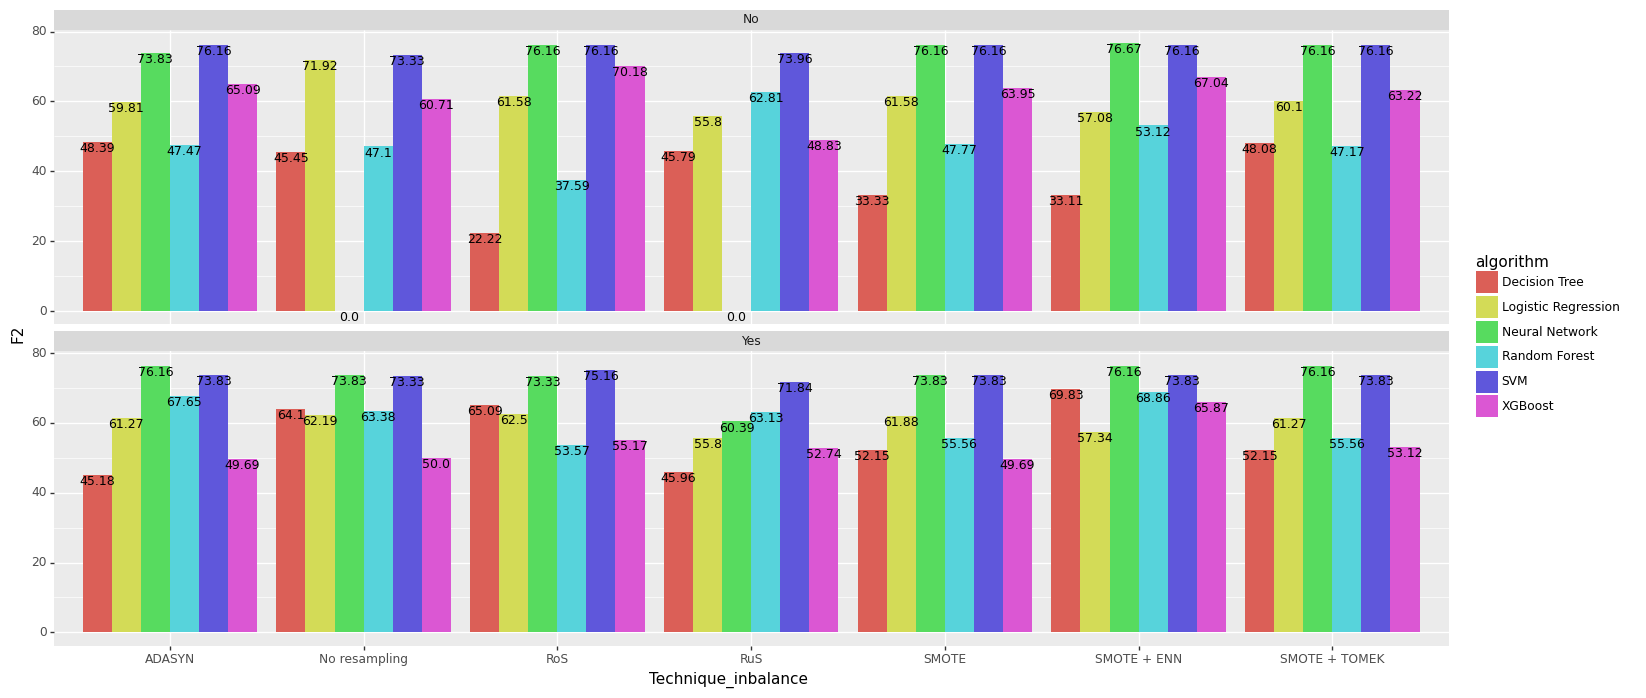

<ggplot: (8761903436701)>

In [79]:
(
   ggplot(data=df_measure)
   + aes(x='Technique_inbalance', y='F2',fill = 'algorithm')
   + geom_bar(stat="identity",position=position_dodge())
   + geom_text(aes(label='F2'), position=position_dodge(width=0.9),size=9,va = 'top')
   + facet_wrap('~hyperpara', dir = "v",nrow = 2)
   + theme(figure_size=(18, 8))  # here you define the plot size
)

Best model according to Gmean

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


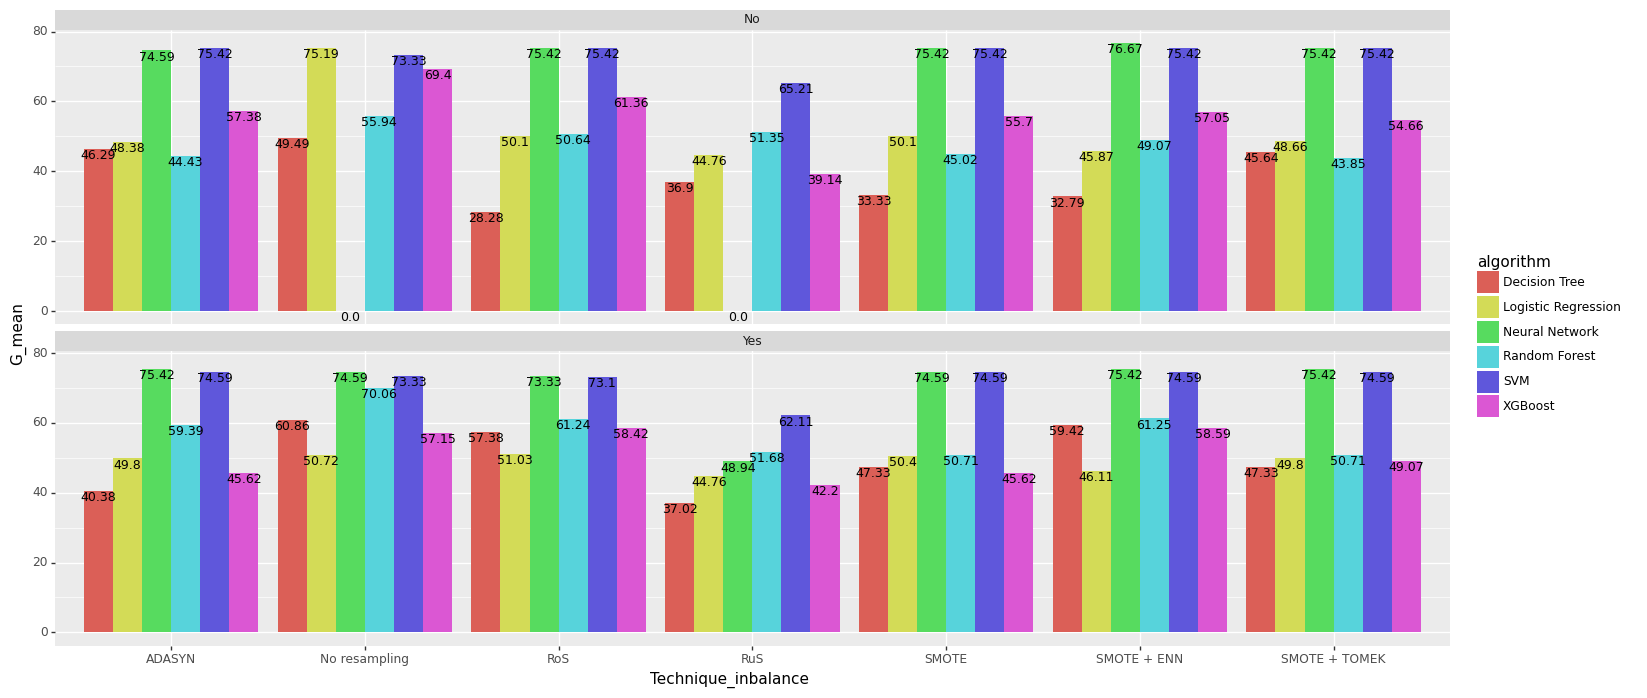

<ggplot: (8761903359633)>

In [80]:
(
   ggplot(data=df_measure)
   + aes(x='Technique_inbalance', y='G_mean',fill = 'algorithm')
   + geom_bar(stat="identity",position=position_dodge())
   + geom_text(aes(label='G_mean'), position=position_dodge(width=0.9),size=9,va = 'top')
   + facet_wrap('~hyperpara', dir = "v",nrow = 2)
   + theme(figure_size=(18, 8))  # here you define the plot size
)

Best Model according to AUC

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


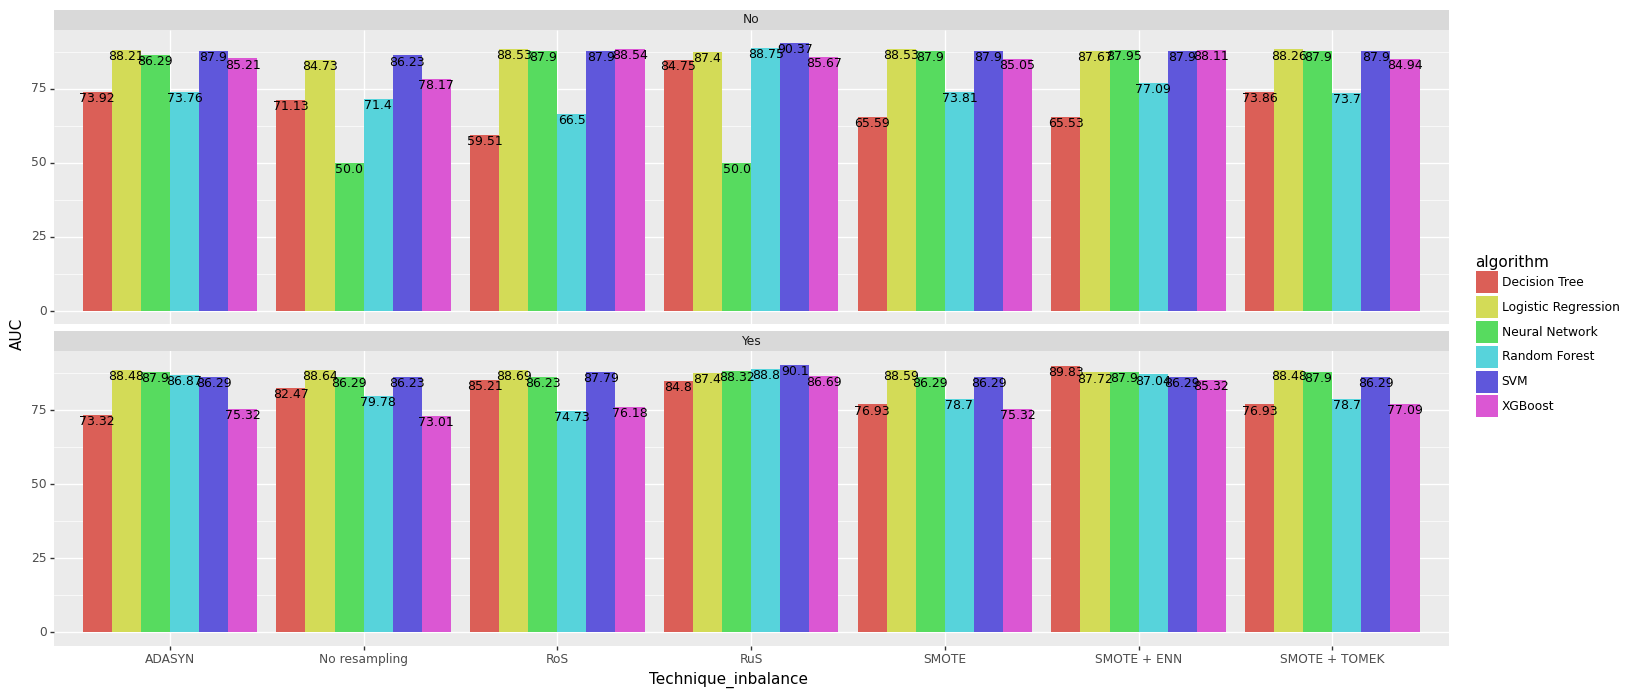

<ggplot: (8761901390573)>

In [81]:
(
   ggplot(data=df_measure)
   + aes(x='Technique_inbalance', y='AUC',fill = 'algorithm')
   + geom_bar(stat="identity",position=position_dodge())
   + geom_text(aes(label='AUC'), position=position_dodge(width=0.9),size=9,va = 'top')
   + facet_wrap('~hyperpara', dir = "v",nrow = 2)
   + theme(figure_size=(18, 8))  # here you define the plot size
)

## Selection of the Threshold

In [83]:
# Model with tuning
from sklearn.model_selection import GridSearchCV
mlp_gs = MLPClassifier(max_iter=500)
param_grid = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, param_grid, n_jobs=-1, cv=3)
model_final = clf.fit(X_train_sm,Y_train_sm)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [131]:
probas = clf.predict_proba(X_test)[:,0]#.tolist()
#probas
probas = pd.Series(probas)
df4 = pd.DataFrame([Y_test,probas], index=['target','probas']).T
df4

target    probas
0       0.0  0.992327
1       0.0  0.999928
2       0.0  0.941237
3       0.0  0.991555
4       0.0  0.999999
..      ...       ...
950     0.0  1.000000
951     0.0  0.999927
952     0.0  0.999998
953     0.0  0.999998
954     0.0  1.000000

[955 rows x 2 columns]

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


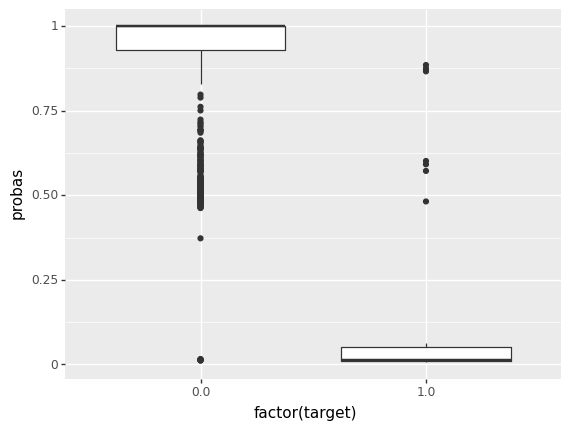

<ggplot: (8761896743925)>

In [134]:
(
    ggplot(df4)
    + geom_boxplot(aes(x='factor(target)', y='probas'))
    #+ scale_x_discrete(labels='target', name='target')  # change ticks labels on OX
)

In [142]:
probas2 = clf.predict_proba(X_train)[:,0]#.tolist()
#probas
probas2 = pd.Series(probas2)
Y_train.reset_index(inplace=True)
df5 = pd.DataFrame([Y_train,probas2], index=['target','probas']).T
df5

TypeError: ignored

TypeError: ignored

Best Threshold: 0.5181 with G-Mean: 0.8837
FPR: 0.0238, TPR: 0.8


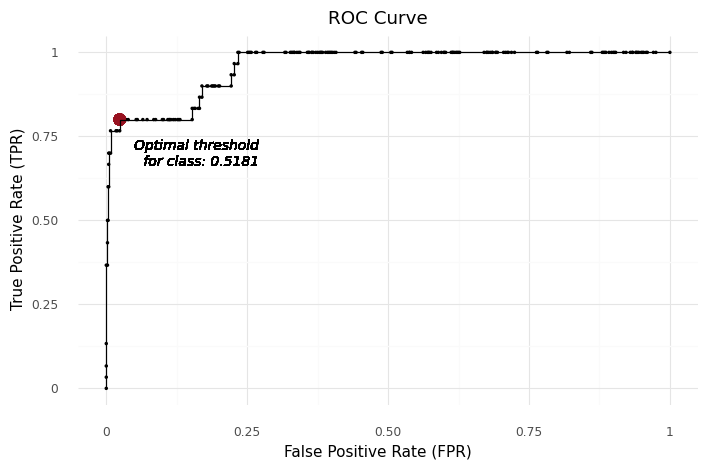

<ggplot: (8761901623357)>

In [148]:
# Get the probabilities for positive class
y_pred = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Best Threshold: 0.9366 with F-Score: 0.7667
Recall: 0.7667, Precision: 0.7667


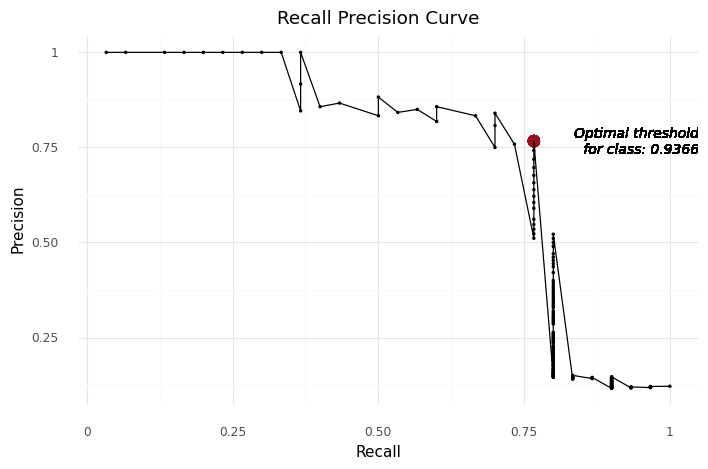

<ggplot: (8761903297693)>

In [151]:
# Create the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, y_pred)

# Plot the ROC curve
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})

# Calculate the f-score
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Length of sequence: 10000
Best Threshold: 0.6272 with F-Score: 0.7667


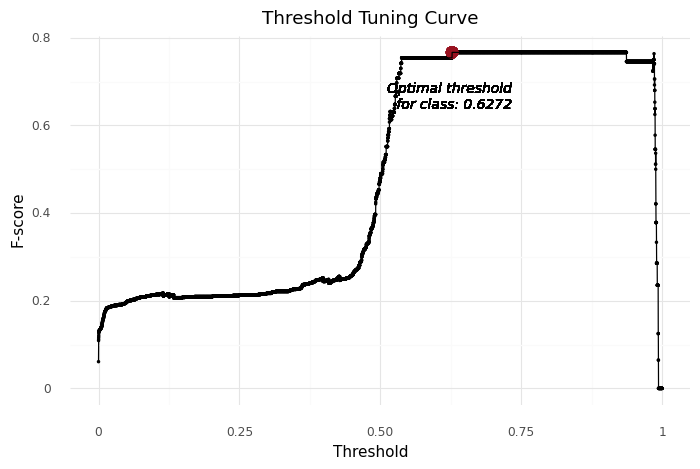

<ggplot: (8761904110717)>

In [153]:
# Array for finding the optimal threshold
thresholds = np.arange(0.0, 1.0, 0.0001)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (y_pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(Y_test, y_pred_prob)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
df_threshold_tuning.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_threshold_tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = thresholdOpt,
                   y = fscoreOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = thresholdOpt,
                  y = fscoreOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)

# Interpretation of the optimal model

## General interpretation : Features importance; PDP ALE

#### Features importances






In [159]:
final_model = model_final.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


YellowbrickTypeError: ignored

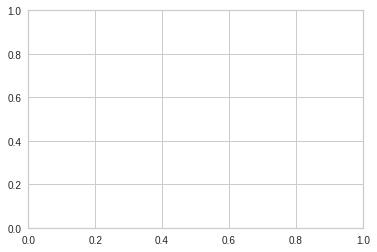

In [161]:
from yellowbrick.features import FeatureImportances
fig, ax = plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(final_model,var_retain)
fi_viz.fit(X_test,Y_test)
fi_viz.poof()

In [168]:
y_predi = clf.predict(X_test)
n_features = len(var_retain)
def get_feature_importance(j, n):
  s = accuracy_score(Y_test, y_predi) # baseline score
  total = 0.0
  for i in range(n):
    perm = np.random.permutation(range(X_test.shape[0]))
    X_test_ = X_test.copy()
    X_test_[:, j] = X_test[perm, j]
    y_pred_ = clf.predict(X_test_)
    s_ij = accuracy_score(Y_test, y_pred_)
    total += s_ij
  return s - total / n


In [ ]:
# Feature importances
f = []
for j in range(X_test.shape[1]):
  f_j = get_feature_importance(j, 100)
  f.append(f_j)

#df
df = pd.DataFrame({"Variables":var_retain,
                  "Importance":f})
df_sorted= df.sort_values('Importance')

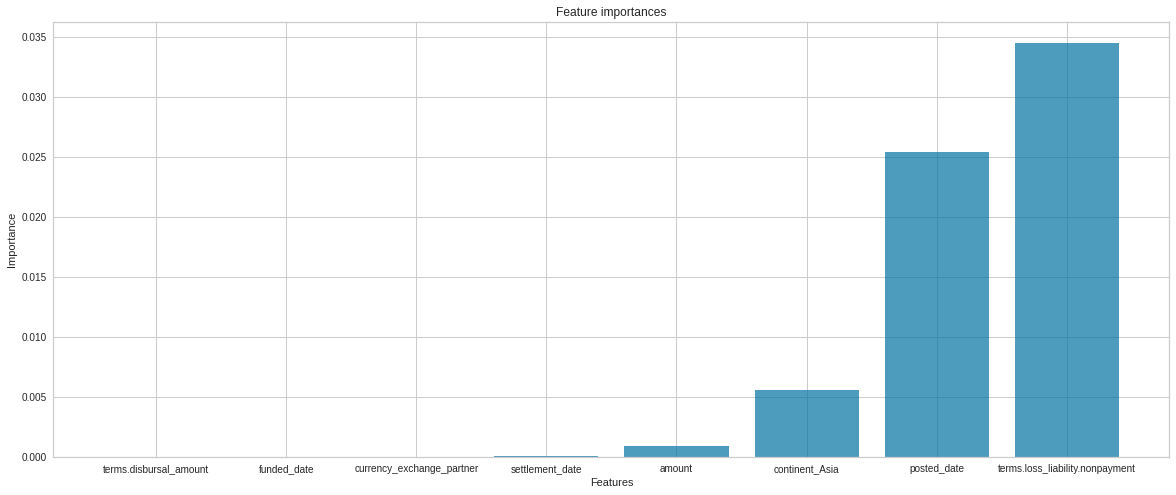

In [177]:
# Plot
plt.figure(figsize=(20,8))
plt.bar('Variables', 'Importance',data=df_sorted, alpha = 0.7)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

#### PDP

#### ALE

## Local interpretation : LIME and SHAP

#### LIME

SHAP